## Real or Not? NLP with Disaster Tweets 
### Predict which Tweets are about real disasters and which ones are not

This particular challenge is one of the getting started Kaggle learning competitions, which can be found [here](https://www.kaggle.com/c/nlp-getting-started/overview/description). It is my first attempt with  **Natural Language Processing**. The notebook will be considerably long and will contain more details/methods than one would expect. 

## Table of contents
* [Competition Description](#Competition-Description)
* [Data Exploration](#Data-Exploration)
* [Target Correction](#Target-Correction)
* [Data Cleaning](#Data-Cleaning)
* [EDA and Feature Engineering](#EDA-and-Feature_Engineering)
    * [WordCloud](#WordCloud)
    * [Meta Features](#Meta-Features)
    * [N-grams](#N-grams)
    * [Topic Modeling](#Topic-Modeling)
    * [Sentiment Analysis](#Sentiment-Analysis)
    * [Name Entity Recognition](#Name-Entity-Recognition)
    * [POS Tagging](#POS-Tagging)
* [Machine Learning](#Machine-Learning)
    * [Bag of Words](#Bag-of-Words)
    * [TF-IDF](#TF-IDF)
    * [GloVe](#GloVe)
    * [BERT](#BERT)
* [Prediction and Submission](#Prediction-and-Submission)
* [Conclusion and Discussion](#Conclusion-and-Discussion)
* [References](#References)

## Competition Description
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).However, it’s not always clear whether a person’s words are actually announcing a disaster. 

In this competition, participants are challenged to build a machine learning model that predicts which Tweets are about real disasters and which ones are not.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove840b300dtxt/glove.840B.300d.txt
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


## Data Exploration

In [2]:
# open train data into a dataframe
train=pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
# open test data into a dataframe
test=pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
#  missing values function
def missing_data(frame):
    total = frame.isnull().sum().sort_values(ascending=False)
    percent = (frame.isnull().sum()/frame.isnull().count()*100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
# check for missing values in training data
missing_data(train)

,Total,Percent
location,2533,33.272035
keyword,61,0.801261
target,0,0.000000
text,0,0.000000
id,0,0.000000


In [5]:
# check for missing value in test data
missing_data(test)

,Total,Percent
location,1105,33.864542
keyword,26,0.796813
text,0,0.000000
id,0,0.000000


**Observation**: 
* Both training and test set have same ratio of missing values in *keyword* and *location* columns. This means that they are most probably taken from the same sample.

In [6]:
# check the shape of both data sets
print('There are {} rows and {} columns in train'.format(train.shape[0],train.shape[1]))
print('There are {} rows and {} columns in test'.format(test.shape[0],test.shape[1]))


There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in test


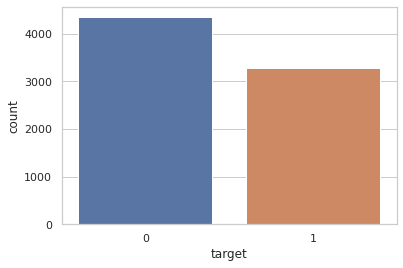

In [7]:
# vizualize the target variable for train set
import seaborn as sns
sns.set(style='whitegrid')
ax=sns.countplot(x='target', data=train)

In [8]:
# display value counts for the target variable in train
pd.value_counts(train['target'])

0    4342
1    3271
Name: target, dtype: int64

In [9]:
# display an example of a non-disaster tweet
train[train["target"] == 0]["text"].values[5]

'this is ridiculous....'

In [10]:
# display an example of a disaster tweet
train[train["target"] == 1]["text"].values[5]

'#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'

In [11]:
# dataframe for non-disaster tweets
train_0=train[train["target"] == 0]
train_0.head()

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0


In [12]:
# check missing data in non-disaster tweets
missing_data(train_0)

,Total,Percent
location,1458,33.578996
keyword,19,0.437586
target,0,0.000000
text,0,0.000000
id,0,0.000000


In [13]:
# dataframe for disaster tweets
train_1=train[train["target"] == 1]
train_1.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [14]:
# check missing data in disaster tweets
missing_data(train_1)

,Total,Percent
location,1075,32.864567
keyword,42,1.284011
target,0,0.000000
text,0,0.000000
id,0,0.000000


In [15]:
# checking the keywords for disaster tweets
list_1=train[train["target"] == 1]["keyword"].values.tolist()
# printing unique words
set(list_1)  


{'ablaze',
 'accident',
 'airplane%20accident',
 'ambulance',
 'annihilated',
 'annihilation',
 'apocalypse',
 'armageddon',
 'army',
 'arson',
 'arsonist',
 'attack',
 'attacked',
 'avalanche',
 'battle',
 'bioterror',
 'bioterrorism',
 'blaze',
 'blazing',
 'bleeding',
 'blew%20up',
 'blight',
 'blizzard',
 'blood',
 'bloody',
 'blown%20up',
 'body%20bag',
 'body%20bagging',
 'body%20bags',
 'bomb',
 'bombed',
 'bombing',
 'bridge%20collapse',
 'buildings%20burning',
 'buildings%20on%20fire',
 'burned',
 'burning',
 'burning%20buildings',
 'bush%20fires',
 'casualties',
 'casualty',
 'catastrophe',
 'catastrophic',
 'chemical%20emergency',
 'cliff%20fall',
 'collapse',
 'collapsed',
 'collide',
 'collided',
 'collision',
 'crash',
 'crashed',
 'crush',
 'crushed',
 'curfew',
 'cyclone',
 'damage',
 'danger',
 'dead',
 'death',
 'deaths',
 'debris',
 'deluge',
 'deluged',
 'demolish',
 'demolished',
 'demolition',
 'derail',
 'derailed',
 'derailment',
 'desolate',
 'desolation',
 'de

In [16]:
# checking the keywords for non-disaster tweets
list_0=train[train["target"] == 0]["keyword"].values.tolist()
# printing unique words
set(list_0) 

{'ablaze',
 'accident',
 'aftershock',
 'airplane%20accident',
 'ambulance',
 'annihilated',
 'annihilation',
 'apocalypse',
 'armageddon',
 'army',
 'arson',
 'arsonist',
 'attack',
 'attacked',
 'avalanche',
 'battle',
 'bioterror',
 'bioterrorism',
 'blaze',
 'blazing',
 'bleeding',
 'blew%20up',
 'blight',
 'blizzard',
 'blood',
 'bloody',
 'blown%20up',
 'body%20bag',
 'body%20bagging',
 'body%20bags',
 'bomb',
 'bombed',
 'bombing',
 'bridge%20collapse',
 'buildings%20burning',
 'buildings%20on%20fire',
 'burned',
 'burning',
 'burning%20buildings',
 'bush%20fires',
 'casualties',
 'casualty',
 'catastrophe',
 'catastrophic',
 'chemical%20emergency',
 'cliff%20fall',
 'collapse',
 'collapsed',
 'collide',
 'collided',
 'collision',
 'crash',
 'crashed',
 'crush',
 'crushed',
 'curfew',
 'cyclone',
 'damage',
 'danger',
 'dead',
 'death',
 'deaths',
 'deluge',
 'deluged',
 'demolish',
 'demolished',
 'demolition',
 'derail',
 'derailed',
 'desolate',
 'desolation',
 'destroy',
 'd

**Observation**: 
* Same keywords can be found in both disaster and non-disaster tweets, thus, we can take a look at their distribution in both types of tweets.

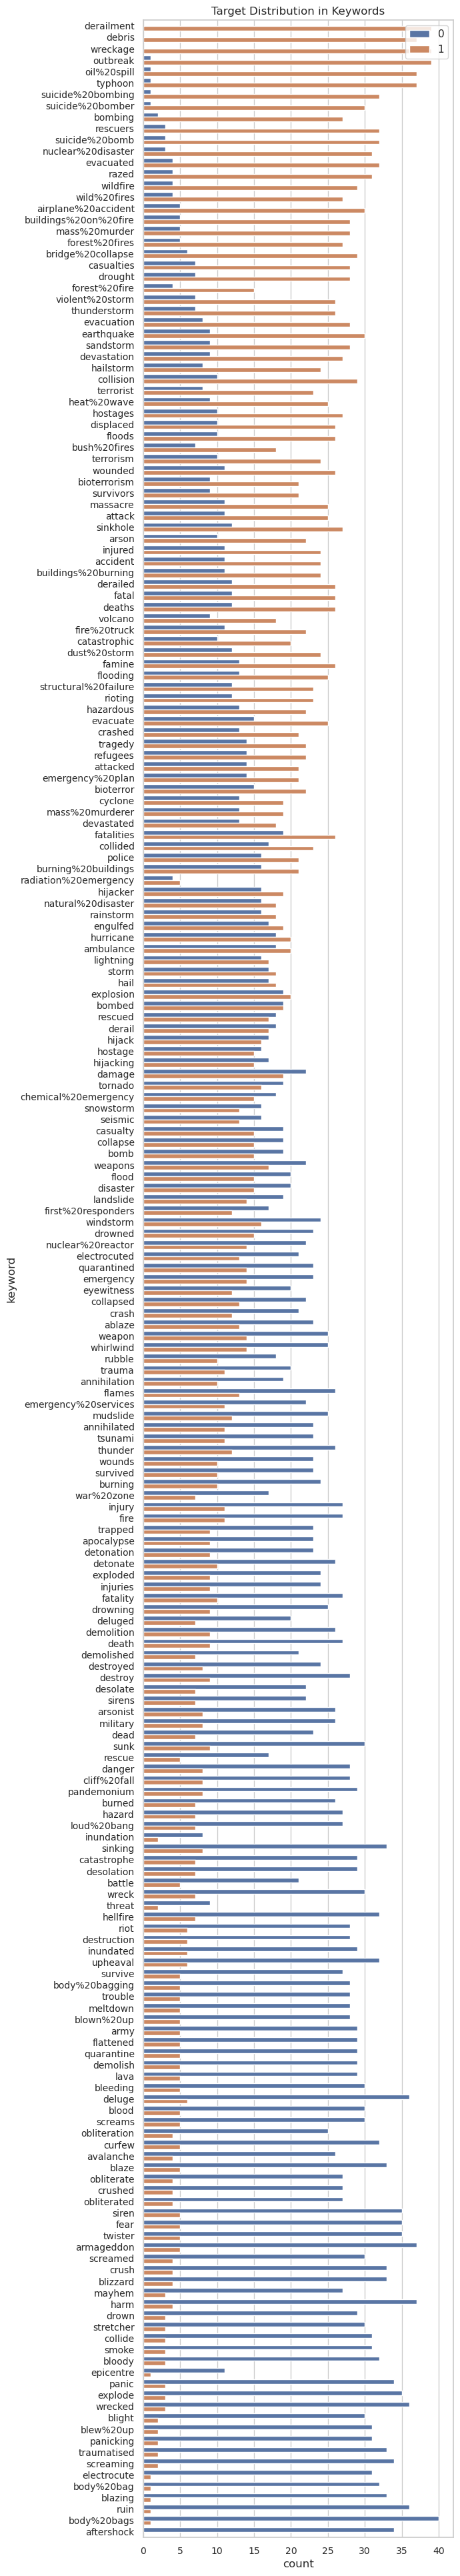

In [17]:
# vizualize distribution of keywords in disaster and non-dister tweets
import matplotlib.pyplot as plt
train['target_mean'] =train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(6, 50), dpi=100)
sns.countplot(y=train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train.sort_values(by='target_mean', ascending=False)['target'])
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')
plt.show()

train.drop(columns=['target_mean'], inplace=True)

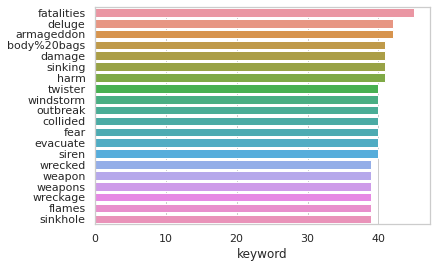

In [18]:
# plotting 20 most common keywords for all tweets
sns.barplot(y=train["keyword"].value_counts()[:20].index,x=train["keyword"].value_counts()[:20],orient='h')

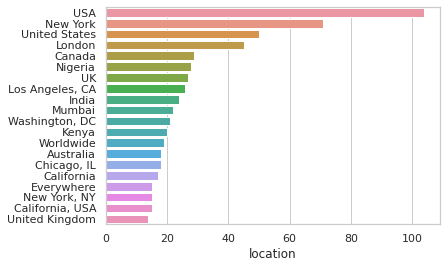

In [19]:
# plotting 10 most common location of tweets
sns.barplot(y=train["location"].value_counts()[:20].index,x=train["location"].value_counts()[:20],orient='h')

**Note**: Location feature is an user input, thus, is very dirty and there are too many unique values in it. Moreover, it might also not be accurate, so it shouldn't be used when creating the model.

In [20]:
# display all hashtags from disaster tweets
import nltk
import re
import itertools
import string
hashtags_1=train_1.text.str.findall(r'#.*?(?=\s|$)') 
hashtags_1=list(itertools.chain(*hashtags_1))
print(hashtags_1, sep=',')


['#earthquake', '#wildfires', '#Alaska', '#wildfires', '#RockyFire', '#CAfire', '#wildfires', '#flood', '#disaster', '#flooding', '#raining', '#flooding', '#Florida', '#TampaBay', '#Tampa', '#Flood', '#We', '#BREAKING', '#AFRICANBAZE:', '#Bridgetown', '#Kurds', '#Diyala', '#California', '#climate', '#energy', '#NashvilleTraffic.', '#SantaClara', '#BayArea', '#Traffic', '#TruckCrash', '#FortWorth', '#Ashville', '#traffic', '#Manchester', '#traffic', '#BREAKING:', '#Hagerstown', '#WHAG', '#Bahrain', '#news', '#Horrible', '#Accident', '#WatchTheVideo', '#KCA', '#VoteJKT48ID', '#RIP', '#BINLADEN', '#MLB', '#man', '#airport', '#airplane', '#aircraft', '#aeroplane', '#runway', '#accident', '#freaky\x89Û_', '#Crash', '#Aircraft', '#Airplane', '#Pilot', '#Death', '#Accident', '#CarFest', '#OMG!', '#RIP', '#AirPlane', '#Accident', '#JetEngine', '#TurboJet', '#Boing', '#G90', '#', '#RODKiai', '#EMSNe\x89Û_', '#yugvani', '#news', '#til_now', '#DNA', '#reuters', '#worldNews', '#worldnews', '#gilbe

In [21]:
# display all hashtags from non-disaster tweets
hashtags_0=train_0.text.str.findall(r'#.*?(?=\s|$)') 
hashtags_0=list(itertools.chain(*hashtags_0))
print(hashtags_0, sep=',')


['#metal', '#RT', '#mufc', '#nsfw', '#nsfw', '#NowPlaying:', '#EDM', '#personalinjury', '#solicitor', '#OtleyHour', '#stlouis', '#caraccidentlawyer', '#ArrestPastorNganga', '#Dubstep', '#TrapMusic', '#DnB', '#EDM', '#Dance', '#Ices\x89Û_', '#Dubstep', '#TrapMusic', '#DnB', '#EDM', '#Dance', '#Ices\x89Û_', '#GrowingUpSpoiled', '#Dubstep', '#TrapMusic', '#DnB', '#EDM', '#Dance', '#Ices\x89Û_', '#Dubstep', '#TrapMusic', '#DnB', '#EDM', '#Dance', '#Ices\x89Û_', '#Dubstep', '#TrapMusic', '#DnB', '#EDM', '#Dance', '#Ices\x89Û_', '#Dubstep', '#TrapMusic', '#DnB', '#EDM', '#Dance', '#Ices\x89Û_', '#Dubstep', '#TrapMusic', '#DnB', '#EDM', '#Dance', '#Ices\x89Û_', '#WisdomWed', '#lifehacks', '#silverwood', '#aftershock', '##book', '#now', '#wdyouth', '#biblestudy', '#justsaying', '#randomthought', '#ems', '#paramedics', '#ambulance', '#Mets', '#FantasticFour/#Fant4stic/whatever', '#LGM', '#gilbert23', '#gilbert23', '#AZ:', '#WildHorses', '#TantoNationalForest!', '#SaltRiverWildHorses', '#science

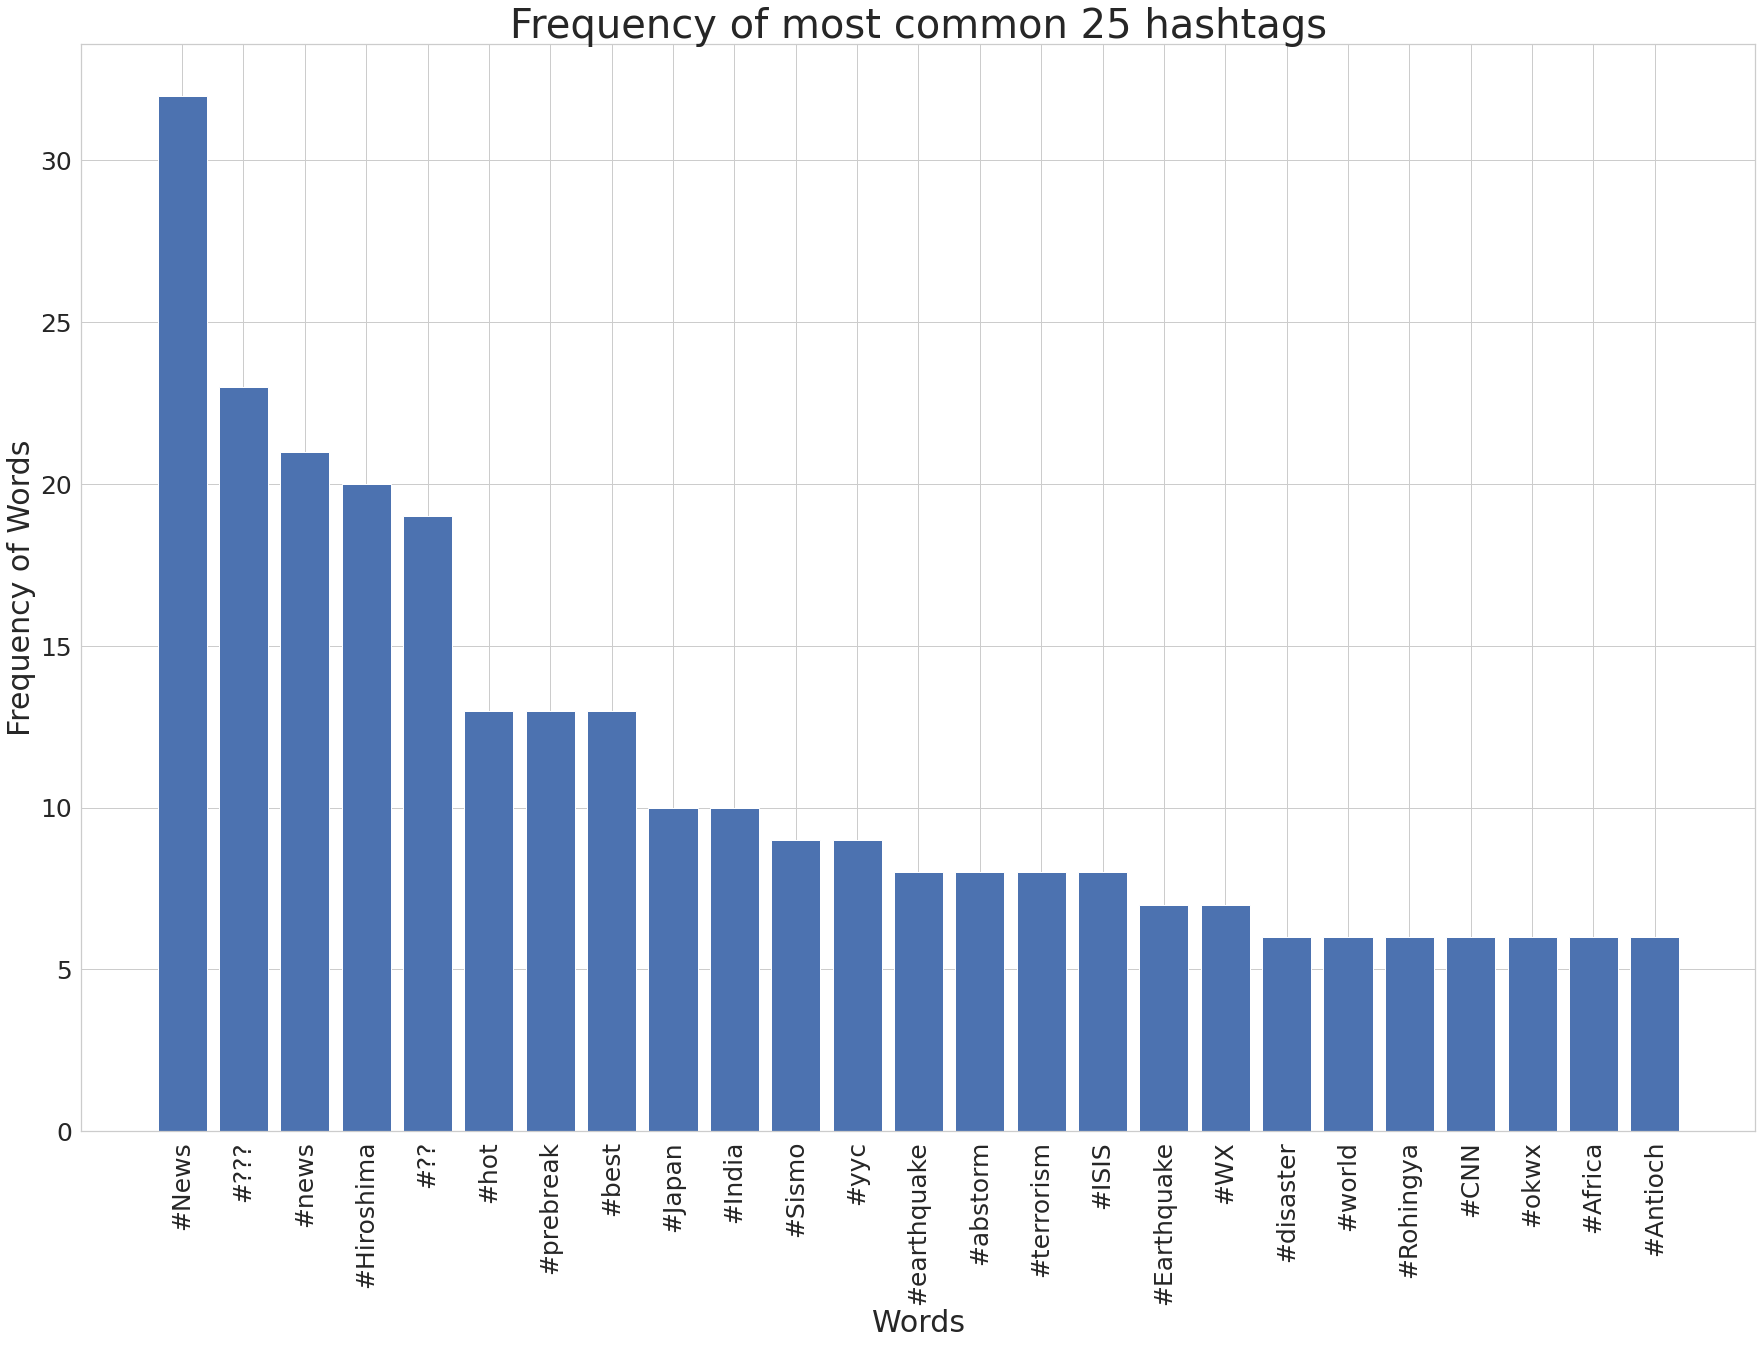

In [22]:
# most common 25 hashtags in disaster tweets
from nltk.probability import FreqDist
common_hashtags=FreqDist(hashtags_1).most_common(25)

# plotting
x,y=zip(*common_hashtags)
plt.figure(figsize=(30,20))
plt.bar(x,y)
plt.xlabel('Words', fontsize=30)
plt.ylabel('Frequency of Words', fontsize=30)
plt.title('Frequency of most common 25 hashtags', fontsize=40)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25, rotation=90)
plt.show()

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


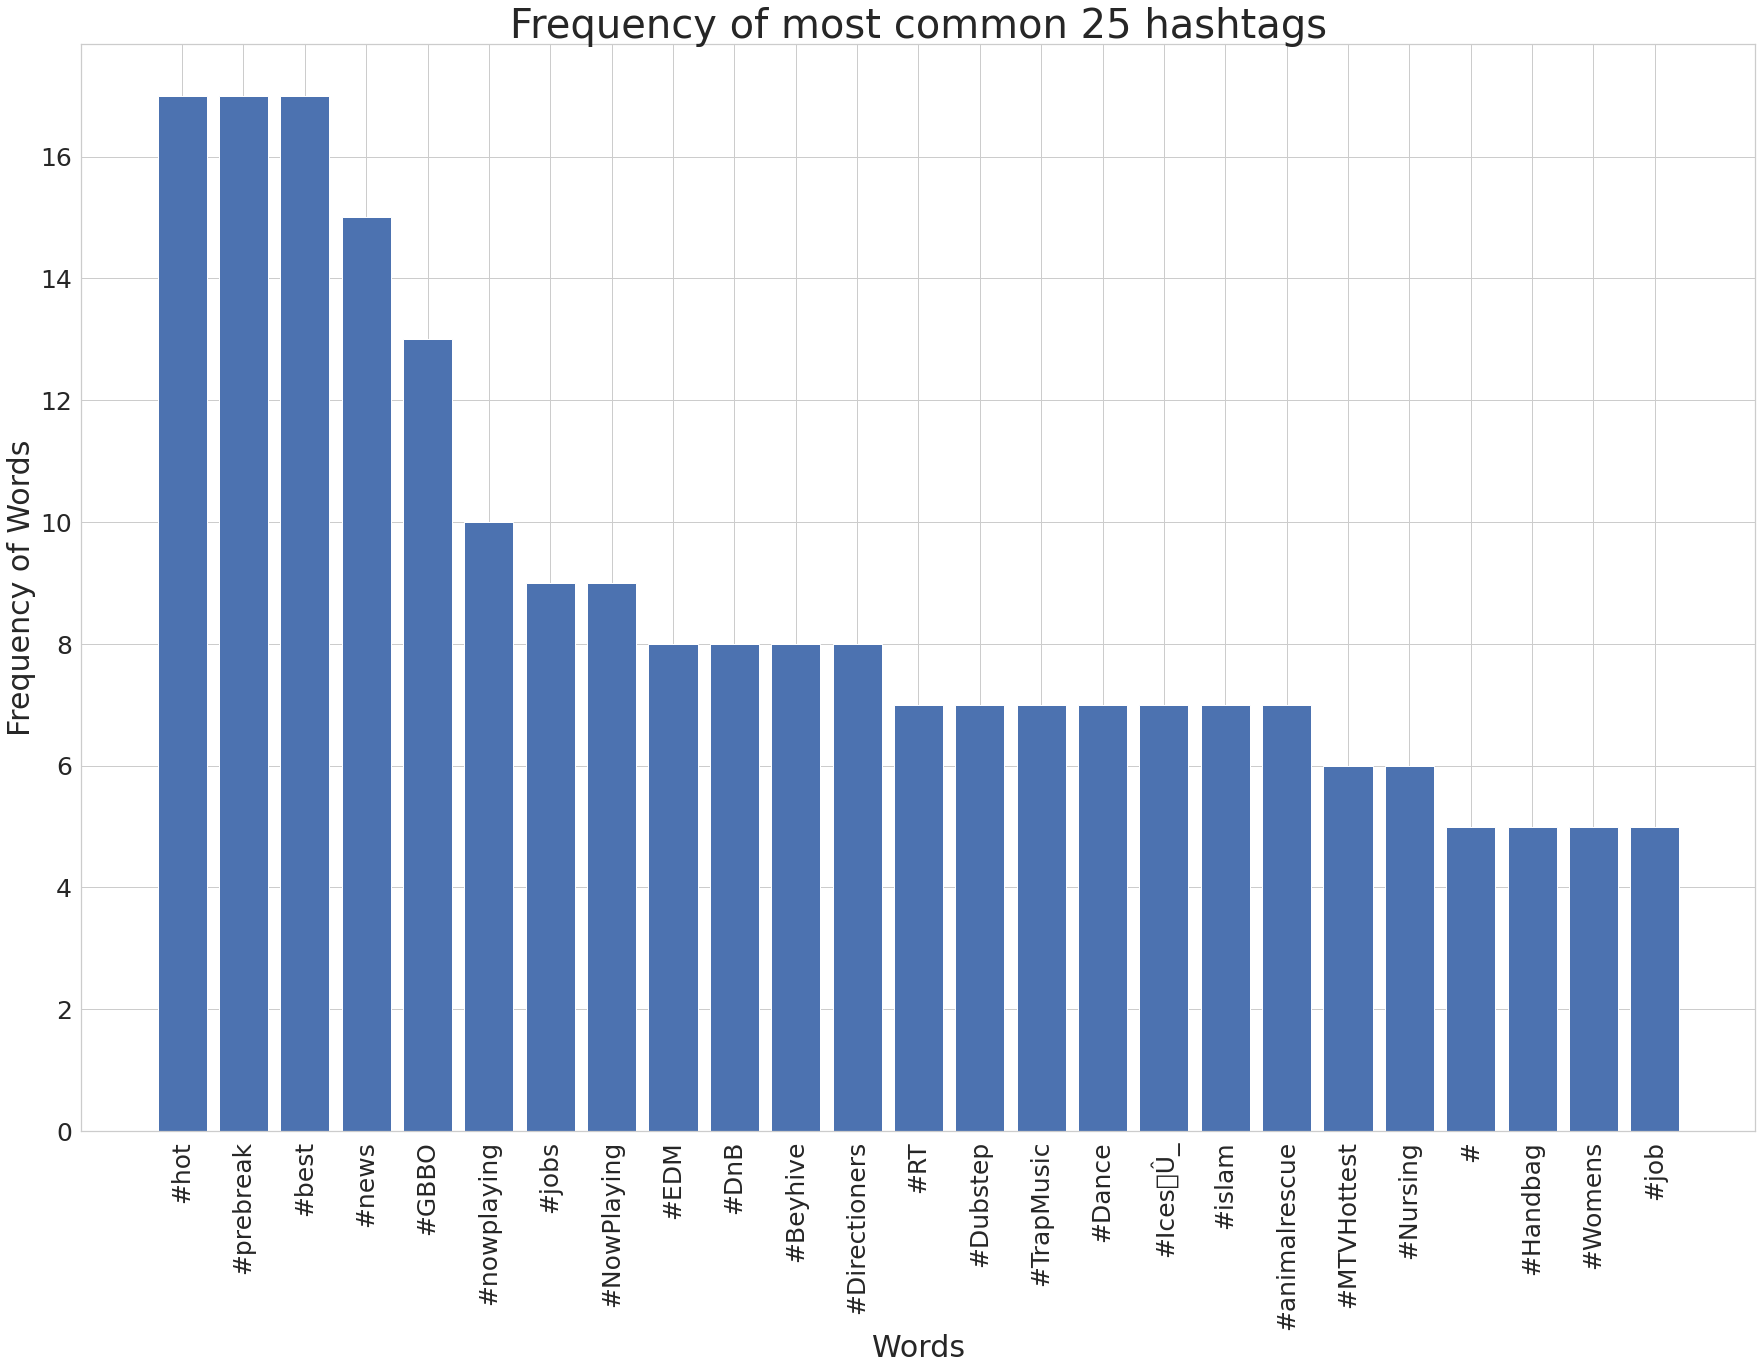

In [23]:
# most common 25 hashtags in tweets non disaster tweets
common_hashtags_0=FreqDist(hashtags_0).most_common(25)

# plotting
x,y=zip(*common_hashtags_0)
plt.figure(figsize=(30,20))
plt.bar(x,y)
plt.xlabel('Words', fontsize=30)
plt.ylabel('Frequency of Words', fontsize=30)
plt.title('Frequency of most common 25 hashtags', fontsize=40)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25, rotation=90)
plt.show()

In [24]:
# display all callouts from disaster tweets
callouts_1=train_1.text.str.findall(r'@.*?(?=\s|$)') 
callouts_1=list(itertools.chain(*callouts_1))
print(callouts_1, sep=',')

['@bbcmtd', '@Navista7', '@News24680', '@nxwestmidlands', '@2:09', '@Your4State.', '@NorwayMFA', '@AlexAllTimeLow', '@YouTube', '@YouTube', '@20skyhawkmm20', '@traplord_29', '@FREDOSANTANA300', '@LilReese300', '@ViralSpell', '@ViralSpell', '@violentfeminazi', '@PhilipDuncan', '@breakfastone', '@TomcatArts', '@ViralSpell', '@rvfriedmann', '@LodiSilverado', '@ritzy_jewels', '@YouTube', '@Change', '@Change', '@CalFreedomMom', '@steph93065', '@willienelson', '@Change', '@Change', '@YahooTV', '@BryanSinger', '@RuPaul', '@AlexShipppp', "@'aRmageddon", '@Erker', '@AP', '@HuffPostRelig', '@latimes)', '@_301DC', '@Cloudy_goldrush', '@VeronicaDLCruz', '@etribune', '@AceBreakingNews', '@darkreading', '@usatoday', '@APHL', '@usatoday', '@abcnorio', '@usatoday', '@USATODAY', '@YouTube', '@CAgov', '@USAgov', '@VP', '@DarrellIssa', '@O_Magazine', '@DrRichardBesser', '@HVnewsnetwork', '@MeyerBjoern', '@thelonevirologi', '@MackayIM', '@StationCDRKelly', '@USAgov', '@AP', '@APhiABeta1907', '@AMESocialAc

In [25]:
# display all callouts from non-disaster tweets
callouts_0=train_0.text.str.findall(r'@.*?(?=\s|$)') 
callouts_0=list(itertools.chain(*callouts_0))
print(callouts_0, sep=',')

['@PhDSquares', '@southridgelife', '@Alexis_Sanchez:', '@\x89Û_', '@ablaze', '@SleepJunkies:', '@flowri', '@afterShock_DeLo', '@djicemoon', '@djicemoon', '@afterShock_DeLo', '@djicemoon', '@djicemoon', '@djicemoon', '@KJForDays', '@djicemoon', '@djicemoon', '@esquireattire', '@OnFireAnders', '@Cod8sandscrims', '@EmpirikGaming', '@CoDAWScrims', '@4TP_KOTC', '@4TPFA', '@afterShock_Org', '@crobscarla', '@mickinyman', '@TheAtlantic', '@TanSlash', '@fouseyTUBE', '@TheNissonian', '@RejectdCartoons', '@Kiwi_Karyn', '@LeoBlakeCarter:', '@natasha_rideout', '@medic914', '@AACE_org', '@marksmaponyane', '@Volfan326', '@TNeazzy', '@ACarewornHeart', '@AmirKingKhan', '@FloydMayweather', '@stormbeard', '@steel_lord', '@TomcatArts', '@SirBrandonKnt', '@thatdes', '@POTUS', '@Change', '@Change', '@KimKardashian', '@TheEllenShow', '@Change', '@Barbi_Twins', '@Whippenz', '@', '@RollingStones', '@SonofBaldwin', '@Change', '@COUNT', '@ANNIHILATION', '@Change', '@HoneyBunzGem', '@primalkitchen', '@alexandrapu

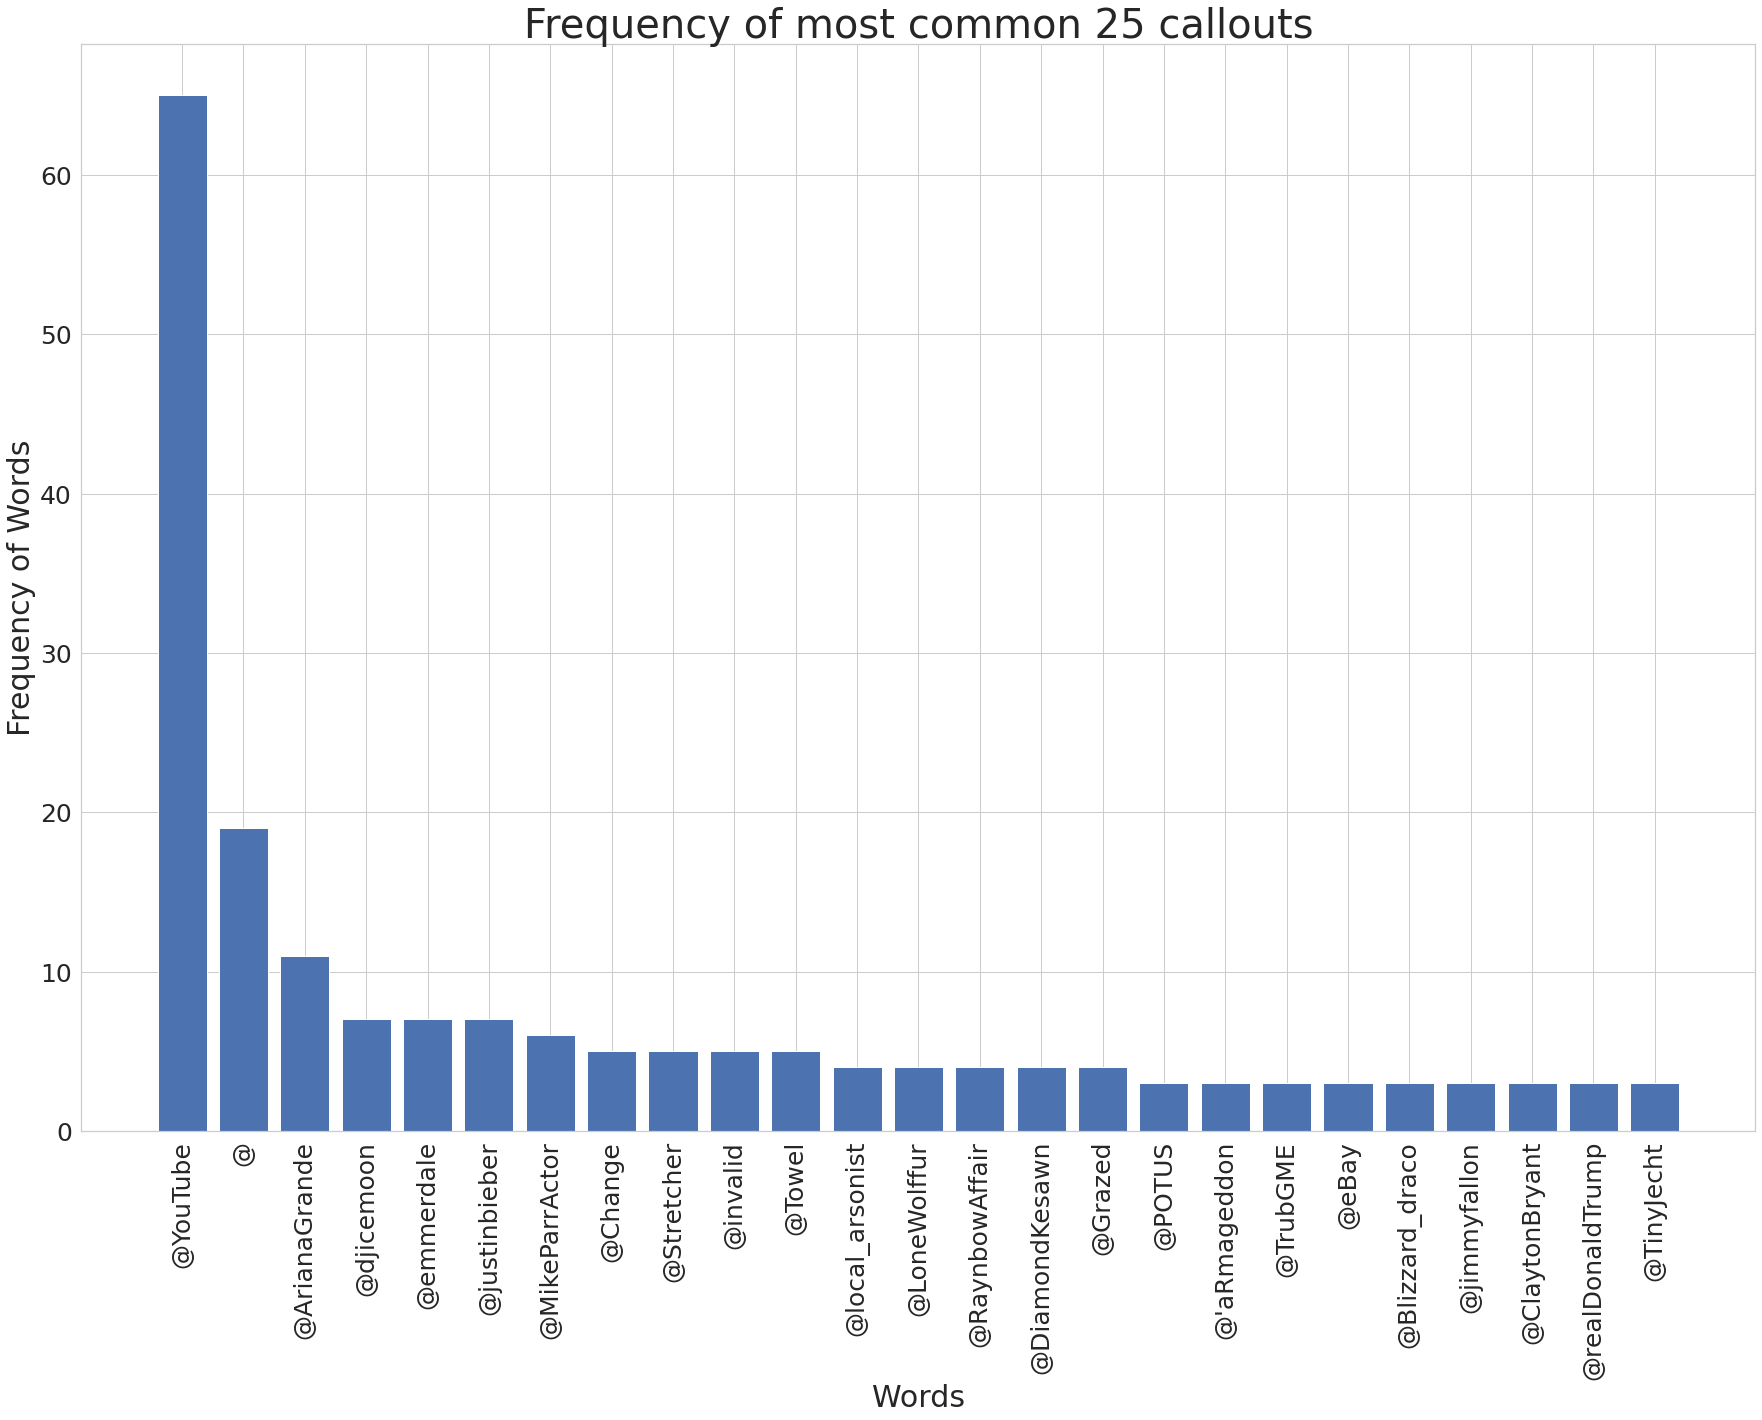

In [26]:
# most common 25 callouts in non-disaster tweets
common_callouts_0=FreqDist(callouts_0).most_common(25)

# plotting
x,y=zip(*common_callouts_0)
plt.figure(figsize=(30,20))
plt.bar(x,y)
plt.xlabel('Words', fontsize=30)
plt.ylabel('Frequency of Words', fontsize=30)
plt.title('Frequency of most common 25 callouts', fontsize=40)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25, rotation=90)
plt.show()

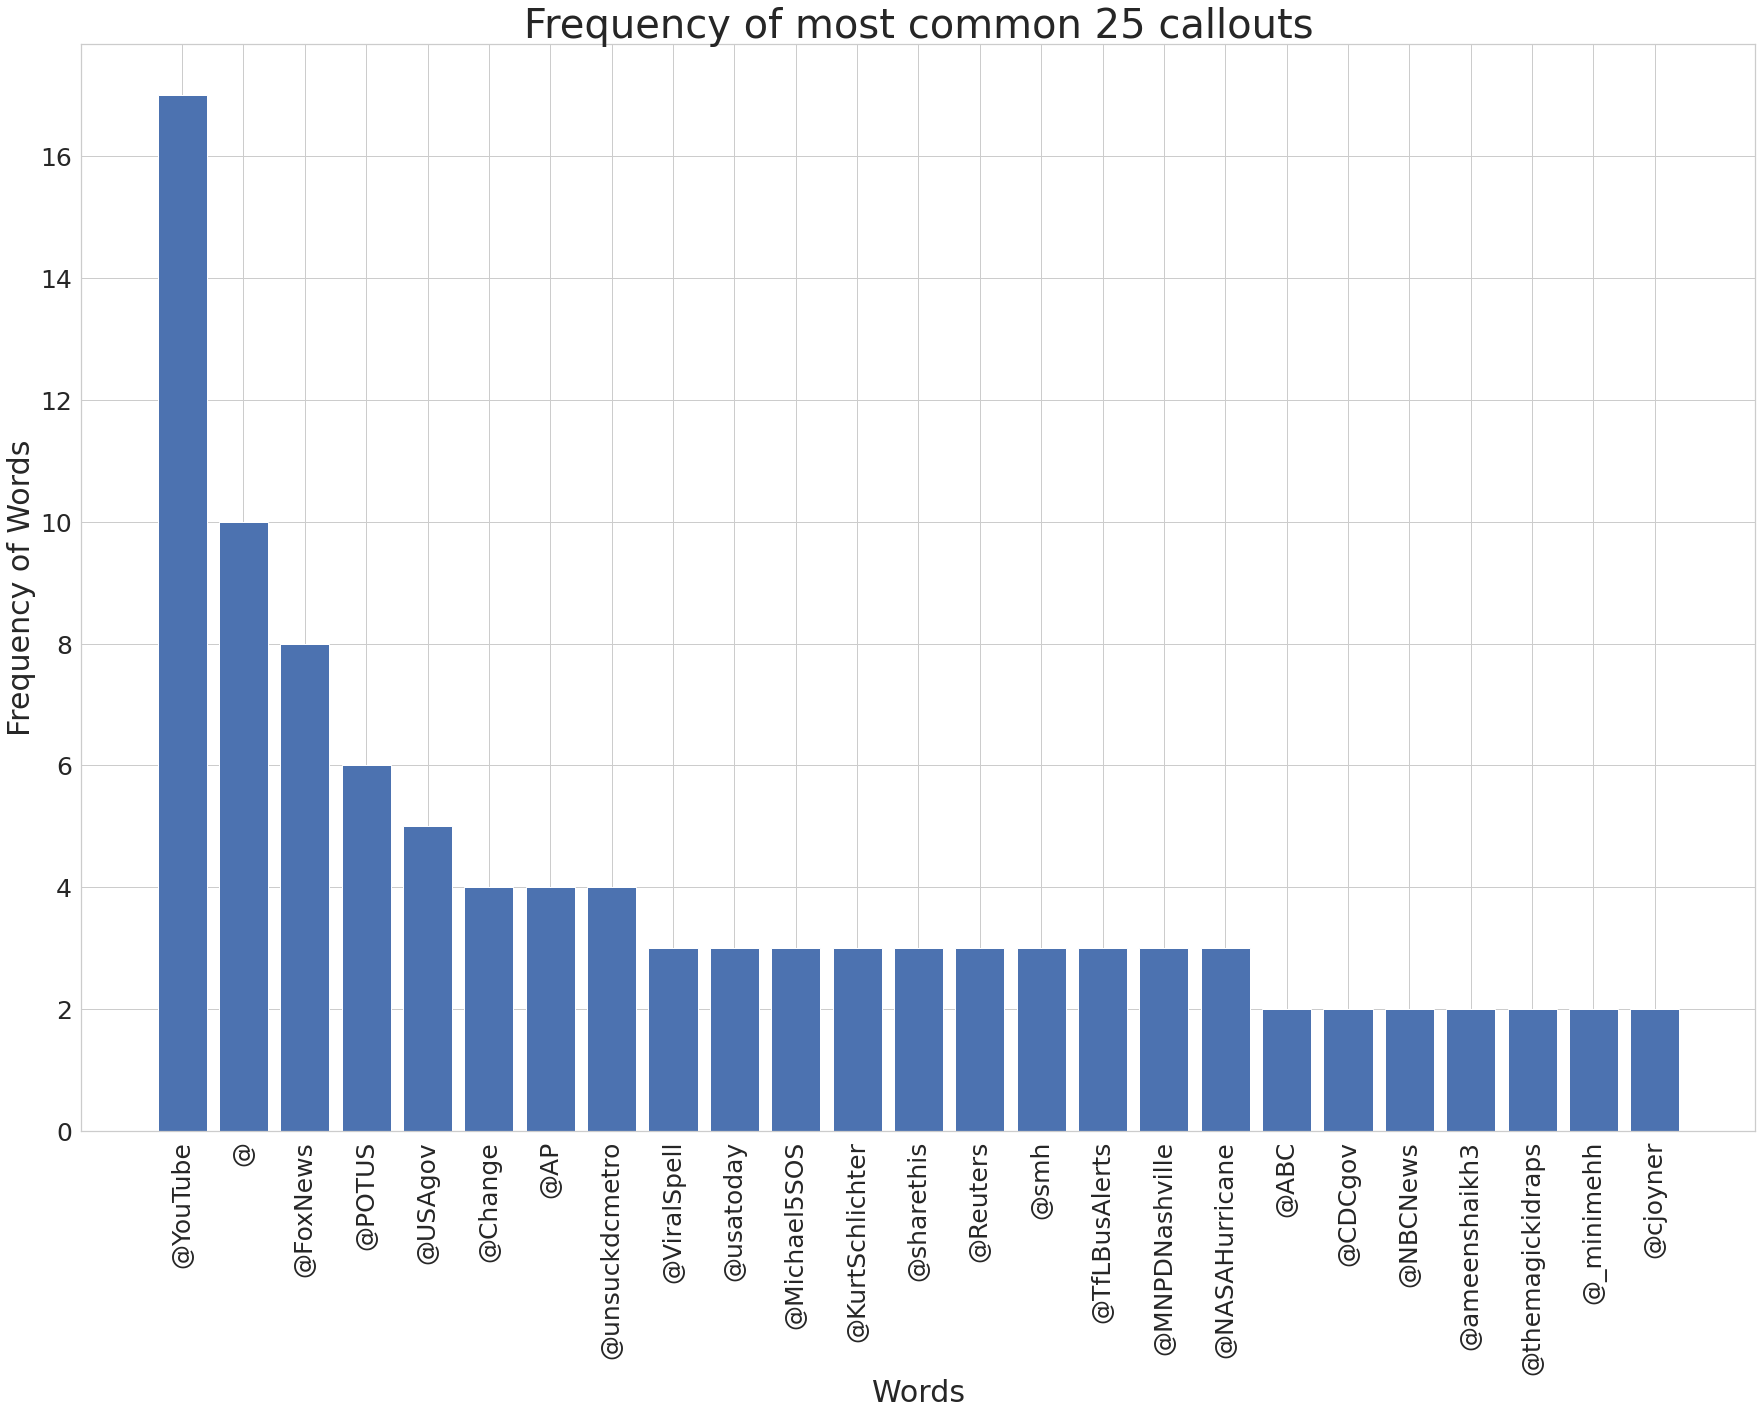

In [27]:
# most common 25 callouts in disaster tweets
common_callouts_1=FreqDist(callouts_1).most_common(25)

# plotting
x,y=zip(*common_callouts_1)
plt.figure(figsize=(30,20))
plt.bar(x,y)
plt.xlabel('Words', fontsize=30)
plt.ylabel('Frequency of Words', fontsize=30)
plt.title('Frequency of most common 25 callouts', fontsize=40)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25, rotation=90)
plt.show()

**Observation**:
* for disaster tweets, the most common callouts are for new channels or governmental entities
* for non-disaster tweets, the most common callouts are for artists and influencers
* callouts for youtube channel are up to 4 times more frequent in non-disaster tweets than in disaster tweets

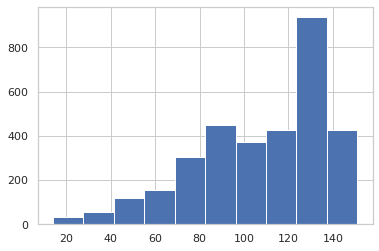

In [28]:
# number of characters in disaster tweets
train_1['text'].str.len().hist()

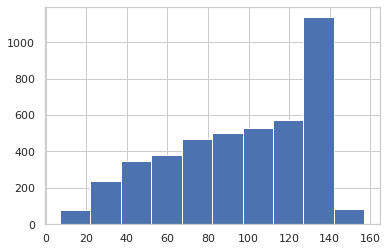

In [29]:
# number of characters in non-disaster tweets
train_0['text'].str.len().hist()

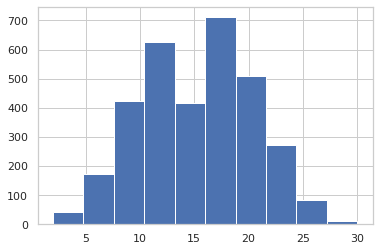

In [30]:
# number of words in disaster tweets
train_1.text.str.split().map(lambda x: len(x)).hist()

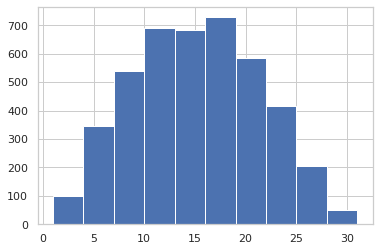

In [31]:
# number of words in non-disaster tweets
train_0.text.str.split().map(lambda x: len(x)).hist()

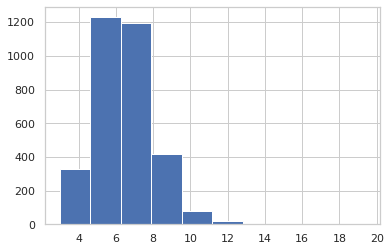

In [32]:
# average word length for disaster tweets
train_1['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

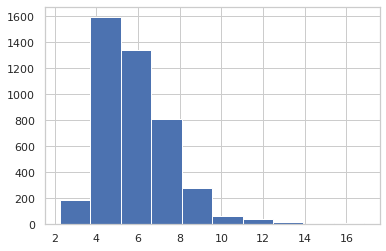

In [33]:
# average word length for non-disaster tweets
train_0['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

**Observation**:
* non-disaster tweets tend to consist of shorter words and have a larger word count.
* disaster tweets are written in a more formal way with longer words compared to non-disaster tweets because most of them are coming from news agencies. 

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


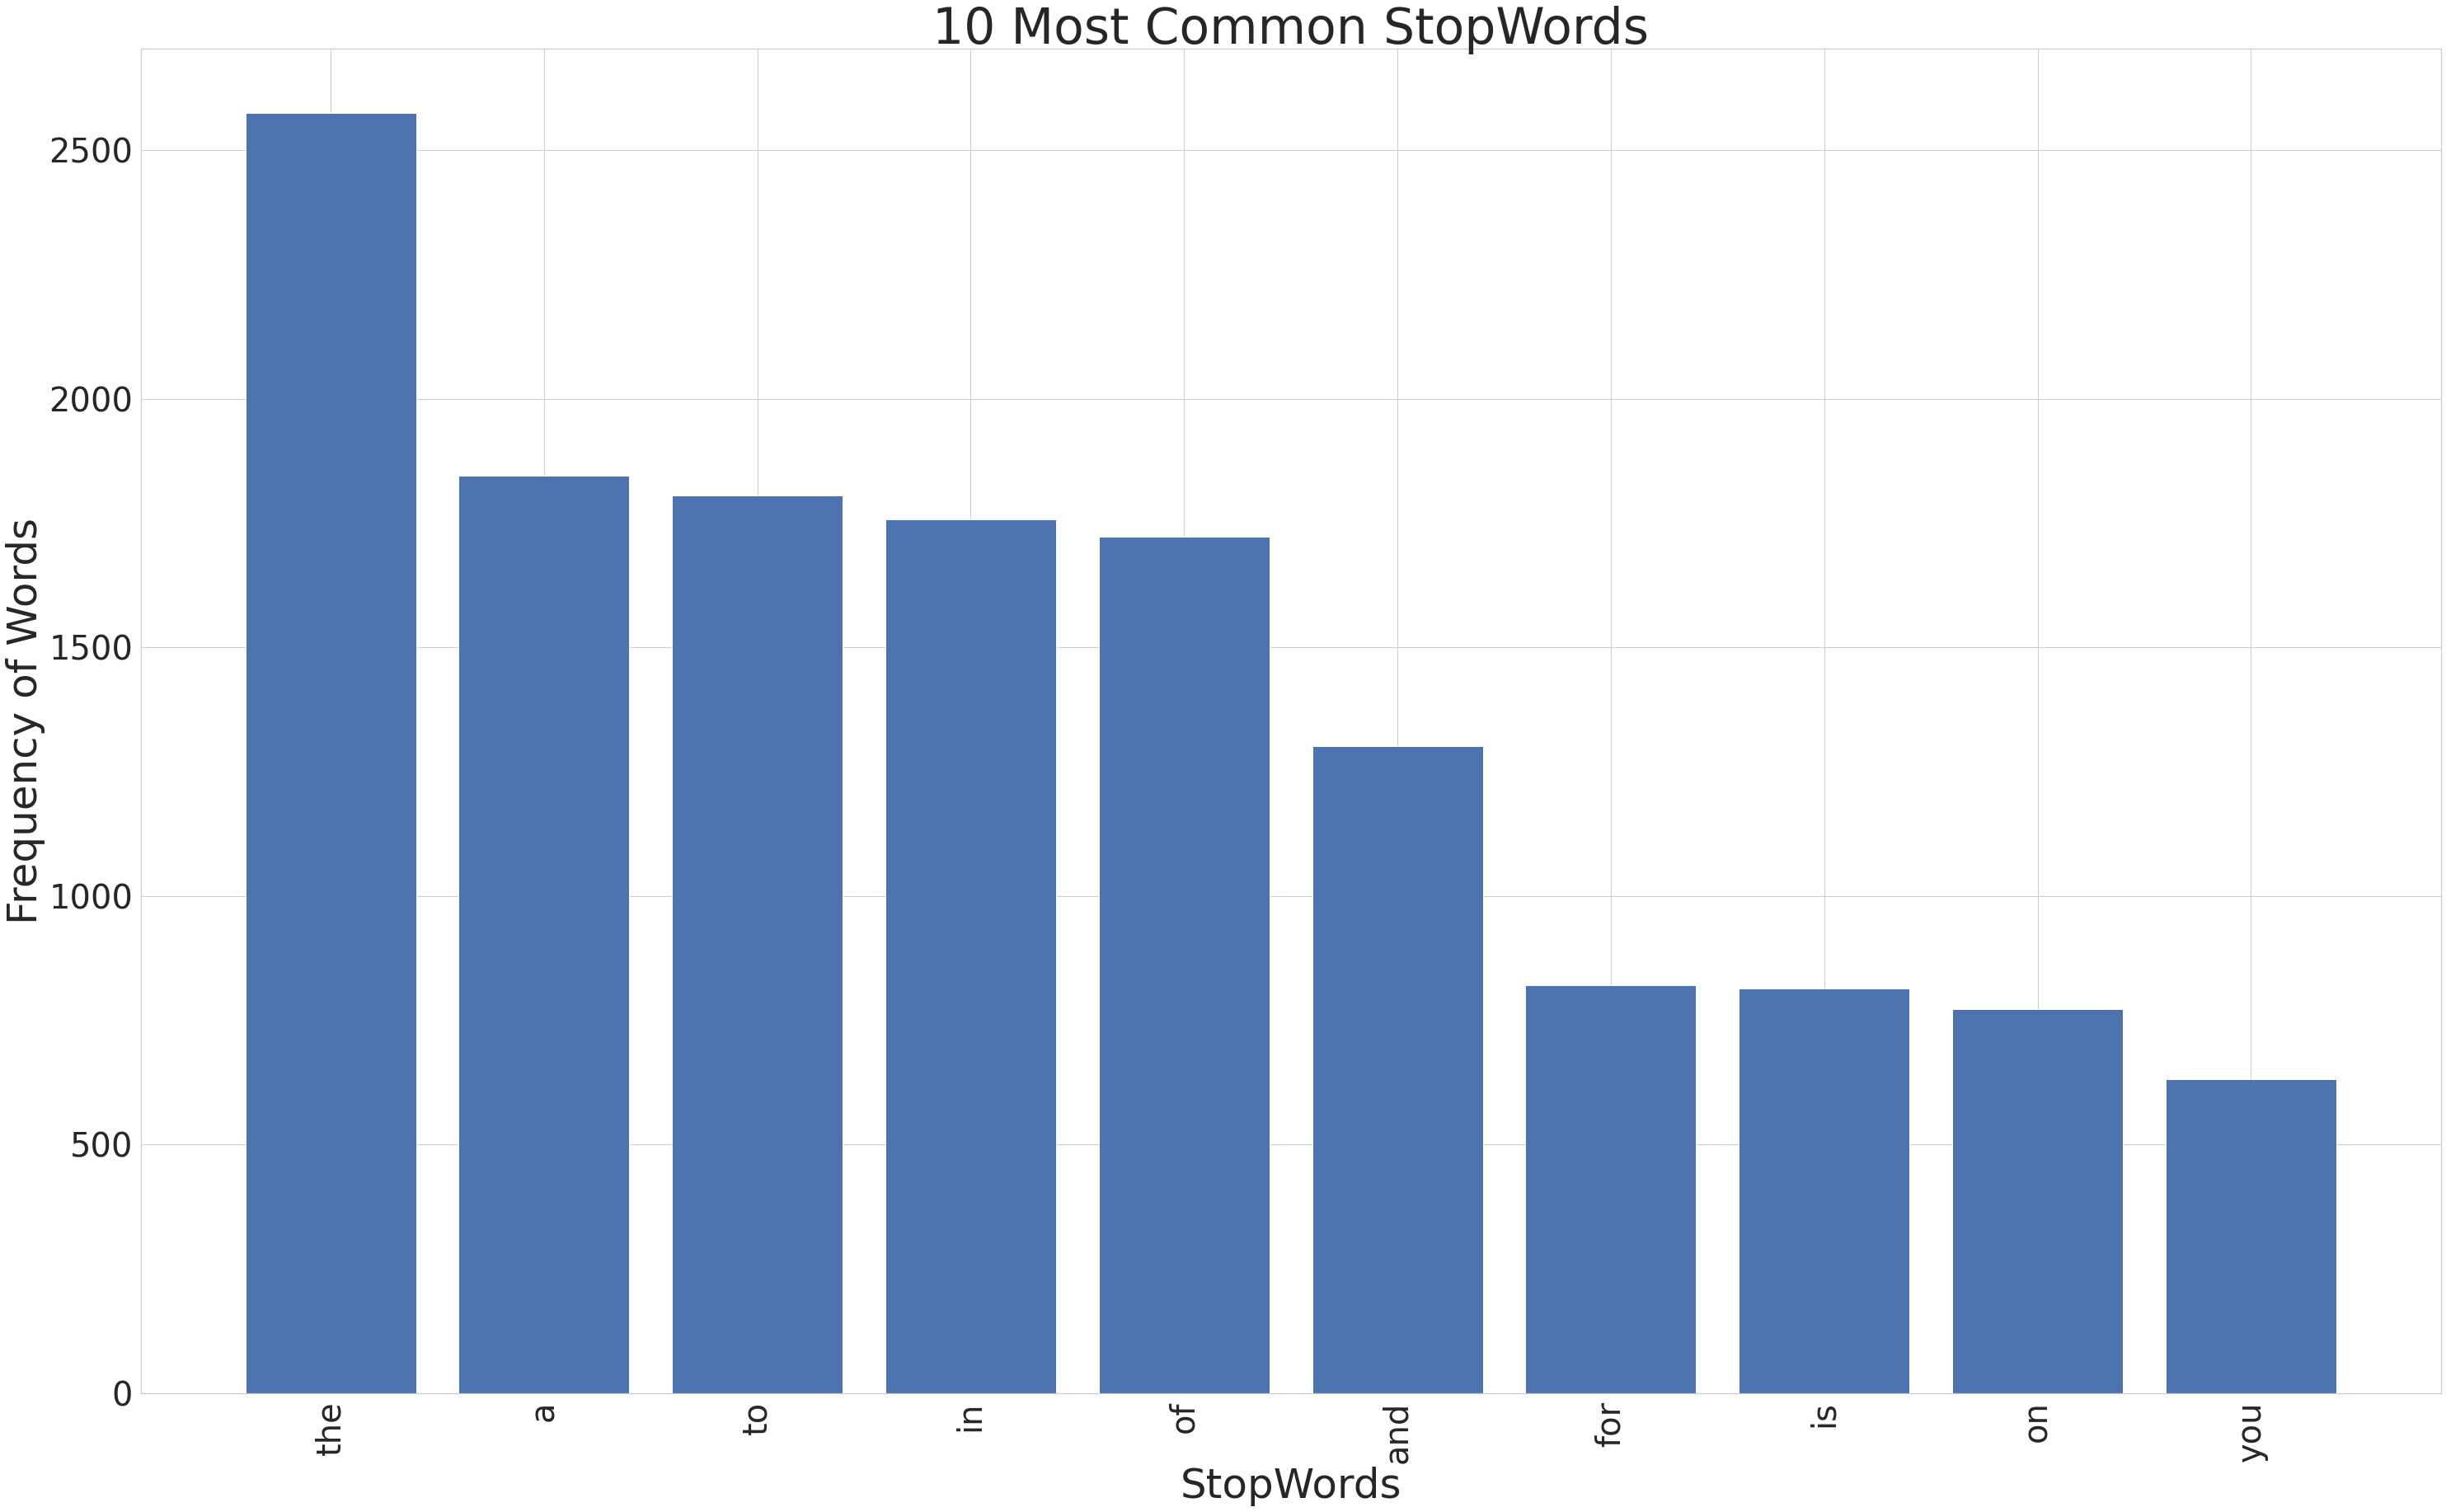

In [34]:
# check for stopwords

# download stopwords dictionary from nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=set(stopwords.words('english'))

# split tweets into words
words=train.text.str.split()
words=words.values.tolist()
corpus=[word for i in words for word in i]

# add existing stopwords to a dictionary
from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1


# plot 10 most common stop words in all tweets        
top_stopwords=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top_stopwords)
plt.figure(figsize=(50,30))
plt.bar(x,y)
plt.xlabel('StopWords', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.title('10 Most Common StopWords', fontsize=60)
plt.yticks(fontsize=40)
plt.xticks(fontsize=40, rotation=90)
plt.show()

In [35]:
# number of unique stopwords
print(len(dic))

148


In [36]:
# total number of stopwords
sum(dic.values())

28542

In [37]:
# check total number of words across all tweets
from nltk.tokenize import word_tokenize
tokens=pd.DataFrame()
tokens['tokenized_sents']=train.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)
tokens['nr_tokens']=tokens.apply(lambda row: len(row['tokenized_sents']), axis=1)
tokens['nr_tokens'].sum()

143742

In [38]:
# calculate the percentage of stopwords 
percentage=sum(dic.values())/tokens['nr_tokens'].sum()*100
percentage

19.856409400175316

## Target Correction

The author of [this](https://www.kaggle.com/wrrosa/keras-bert-using-tfhub-modified-train-data) kernel figured out that there are some errors in the trainng data. Some tweets were tagged as disaster tweets but they weren't. The code belowe corrects these errors.

In [39]:
# correcting target variables
ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]
train.loc[train['id'].isin(ids_with_target_error),'target'] = 0
train[train['id'].isin(ids_with_target_error)]

,id,keyword,location,text,target
229,328,annihilated,NaN,Ready to get annihilated for the BUCS game,0
301,443,apocalypse,NaN,Short Reading\n\nApocalypse 21:1023 \n\nIn the...,0
356,513,army,Studio,But if you build an army of 100 dogs and their...,0
1822,2619,crashed,NaN,My iPod crashed..... \n#WeLoveYouLouis \n#MTVH...,0
2536,3640,desolation,"Quilmes , Arg",This desperation dislocation\nSeparation conde...,0
2715,3900,devastated,PG Chillin!,Man Currensy really be talkin that talk... I'd...,0
3024,4342,dust%20storm,chicago,Going to a fest? Bring swimming goggles for th...,0
4068,5781,forest%20fires,NaN,Campsite recommendations \nToilets /shower \nP...,0
4609,6552,injury,Saint Paul,My prediction for the Vikings game this Sunday...,0
4611,6554,injury,NaN,Dante Exum's knee injury could stem Jazz's hop...,0


## Data Cleaning

For cleaning and pre-processing the data we will take the following steps:
*  **transform negations and abbreviations** in order to make it easier for the system to understand and interpret
*  **tokenize**- convert the normal text strings into a list of tokens
* **remove**  links, special characters, emojis and strings with digits
* **lower case** the text
* **remove stopwords**- common words which would have little to no value in helping select documents 
* **correct spelling**
* **lematize**- reduce words to their dictionary form

We will apply these pre-processing techniques on both training and test data.

In [40]:
# load dictionary for negations

negations = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [41]:
# dealing with negations
train['text']=train['text'].apply(lambda x:' '.
                                  join([negations[word] if word in negations 
                                        else word for word in x.split()]))
test['text']=test['text'].apply(lambda x:' '.
                                  join([negations[word] if word in negations
                                        else word for word in x.split()]))
train['text'][25]

'No way...I cannot eat that shit'

In [42]:
# load dictionary for abbreviations
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
     "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
      "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
      "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
      "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
     "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
       "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
       "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
       "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
      "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
      "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
      "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [43]:
# dealing with abbreviations
train['text']=train['text'].apply(lambda x:' '.
                                  join([abbreviations[word] if word in abbreviations
                                        else word for word in x.split()]))
test['text']=test['text'].apply(lambda x:' '.
                                  join([abbreviations[word] if word in abbreviations
                                        else word for word in x.split()]))


In [44]:
# tokenization, removing links, special characters, emojis and strings with digits
from nltk.tokenize import WordPunctTokenizer

def clean_tweets(tweet):
    user_removed = re.sub(r'@[A-Za-z0-9]+','',tweet)
    link_removed = re.sub(r'http[s]?://\S+','',user_removed)  
    remove_comma_numbers=re.sub(r'[\$,]', '', link_removed)    #removes the comma in nr
    only_alphanumeric = re.sub(r'[^a-zA-Z0-9]', ' ',  remove_comma_numbers)    #removes emojis, punctuation
    no_numeric = re.sub('\D+\d+', ' ', only_alphanumeric)   #removes strings with digit   
    tok = WordPunctTokenizer()
    words = tok.tokenize(no_numeric)
    clean_tweet = (' '.join(words)).strip()
    return clean_tweet


In [45]:
train['text'] = train['text'].apply(clean_tweets)
test['text'] = test['text'].apply(clean_tweets)
train


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked to shelter in place are be...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,ahrary The out of control wild fires in Califo...,1
7610,10871,NaN,NaN,km S of Volcano Hawaii,1
7611,10872,NaN,NaN,Police investigating after an e bike collided ...,1


In [46]:
# lowercasing
train['text']=train['text'].apply(lambda x: x.lower())
test['text']=test['text'].apply(lambda x: x.lower())
train

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,ahrary the out of control wild fires in califo...,1
7610,10871,NaN,NaN,km s of volcano hawaii,1
7611,10872,NaN,NaN,police investigating after an e bike collided ...,1


In [47]:
# removing stopwords
train['text'] = train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test['text'] = test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
train

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding bridge collapse nearb...,1
7609,10870,NaN,NaN,ahrary control wild fires california even nort...,1
7610,10871,NaN,NaN,km volcano hawaii,1
7611,10872,NaN,NaN,police investigating e bike collided car littl...,1


In [48]:
train['text'][7612]

'latest homes razed northern california wildfire abc news'

In [49]:
# spelling correction
# takes long to run
from textblob import TextBlob
train['text'].apply(lambda x: str(TextBlob(x).correct()))
train.text.apply(lambda x: " ".join([TextBlob(i).correct() for i in x.split()]))
test['text'].apply(lambda x: str(TextBlob(x).correct()))
test.text.apply(lambda x: " ".join([TextBlob(i).correct() for i in x.split()]))

In [50]:
# lemmatization
from nltk.stem import WordNetLemmatizer 
from textblob import Word
train['text'] = train['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
test['text'] = test['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
train

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,resident asked shelter place notified officer ...,1
3,6,NaN,NaN,13000 people receive wildfire evacuation order...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,two giant crane holding bridge collapse nearby...,1
7609,10870,NaN,NaN,ahrary control wild fire california even north...,1
7610,10871,NaN,NaN,km volcano hawaii,1
7611,10872,NaN,NaN,police investigating e bike collided car littl...,1


In [51]:
train['text'][99]

'car even week got fucking car accident mf cannot fucking drive'

## EDA and Feature Engineering

### WordCloud

We can represent text data using **WordCloud**. The size and color of each word that appears in the wordcloud indicate it’s frequency or importance.

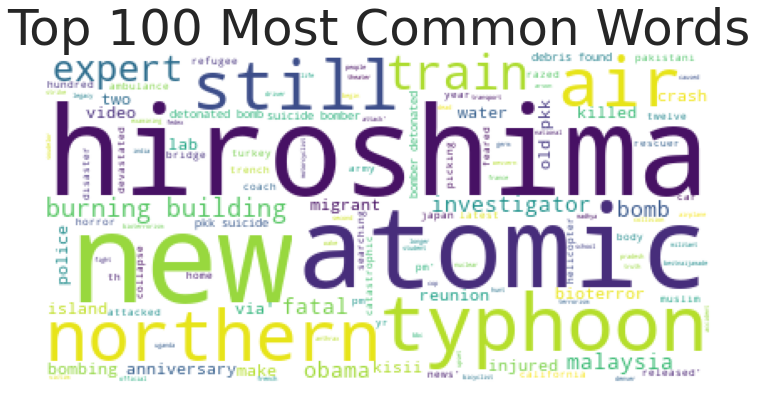

In [52]:
# WordCloud for disaster tweets
from wordcloud import WordCloud, ImageColorGenerator
mostcommon=FreqDist(train[train["target"] == 1]["text"]).most_common(100)
wordcloud=WordCloud(background_color='white').generate(str(mostcommon))

plt.figure(figsize=(12,8), facecolor='white')
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=50)
# plt.tight_layout(pad=0)
plt.show()

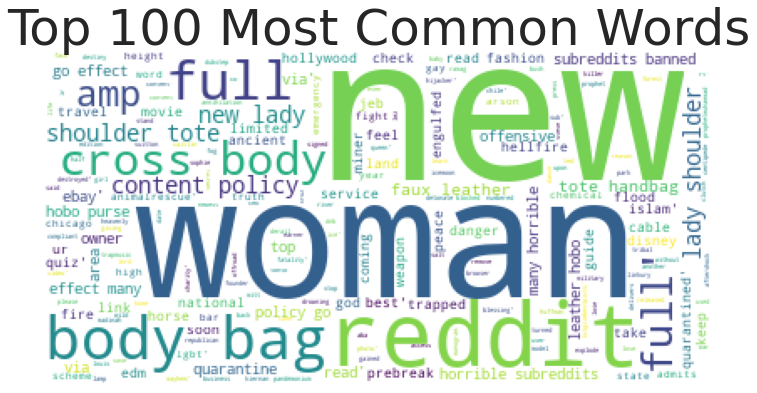

In [53]:
# WordCloud non-disaster tweets
from wordcloud import WordCloud, ImageColorGenerator
mostcommon=FreqDist(train[train["target"] == 0]["text"]).most_common(100)
wordcloud=WordCloud(background_color='white').generate(str(mostcommon))

plt.figure(figsize=(12,8), facecolor='white')
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=50)
# plt.tight_layout(pad=0)
plt.show()

### Meta Features

Creating Meta Features and including them in our training data can have a considerable effect on determining which tweets are disaster tweets. As seen in the first section of the notebook, disaster tweets are usually longer and mostly written in a formal way as they are posted by news agencies, while non-disaster tweets are shorter, have more typos and special characters as they are posted by individual users. Knowing the word count, number of punctuations or urls can actually help classify a tweeet.

We will create the following meta features from our data:
* `word_count`- number of words 
*` unique_word_count`- number of unique words 
* `stop_word_coun`- number of stop words 
* `url_count`- number of urls 
* `mean_word_length`- average character count 
* `char_count`- number of characters 
* `punctuation_count`- number of punctuations 
* `hashtag_count`- number of hashtags (#) 
* `mention_count`- number of mentions (@) 
* `happy_emoji_count´`- number of happy emojis 
* `sad_emoji_count`- number of sad emojis 

In [54]:
# word_count
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
test['word_count'] =test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train['stop_word_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords.words('english')]))
test['stop_word_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords.words('english')]))

# url_count
train['url_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test['url_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train['mean_word_length'] = train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_length'] = test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train['char_count'] = train['text'].apply(lambda x: len(str(x)))
test['char_count'] = test['text'].apply(lambda x: len(str(x)))

# punctuation_count
train['punctuation_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test['punctuation_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
train['hashtag_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test['hashtag_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
train['mention_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test['mention_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

#happy_emoji_count
train['happy_emoji_count'] = train['text'].apply(lambda x: sum(str(x).count(w) for w in (':-)', ':)', ';-)', ':D', ':-D', ';)', ':P', ':-P')))
test['happy_emoji_count'] = test['text'].apply(lambda x: sum(str(x).count(w) for w in (':-)', ':)', ';-)', ':D', ':-D', ';)', ':P', ':-P')))

#sad_emoji_count
train['sad_emoji_count'] = train['text'].apply(lambda x: sum(str(x).count(w) for w in (':-(', ':(', ';-(', ':-@', ":@")))
test['sad_emoji_count'] = test['text'].apply(lambda x: sum(str(x).count(w) for w in (':-(', ':(', ';-(', ':-@', ":@")))

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


### N-grams

Looking at most frequent n-grams can give a better understanding of the context in which the word was used. 

For determining this, the text should be transformed in a matrix so that it can be read by the computer. With **Countvectorizer** we can transform the words in an occurance matrix showing how many times a token appeared in a sentence/document. 

In [55]:

# function for selecting top 10 n-grams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

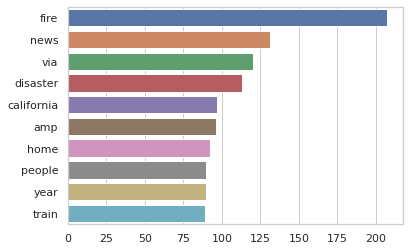

In [56]:
#top unigrams in disaster tweets
top_unigrams_disaster=get_top_ngram(train[train["target"] == 1]["text"],1)[:20]
x,y=map(list,zip(*top_unigrams_disaster))
sns.barplot(x=y,y=x)

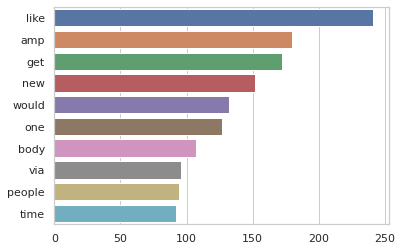

In [57]:
#top unigrams in non-disaster tweets
top_unigrams_nondisaster=get_top_ngram(train[train["target"] == 0]["text"],1)[:20]
x,y=map(list,zip(*top_unigrams_nondisaster))
sns.barplot(x=y,y=x)

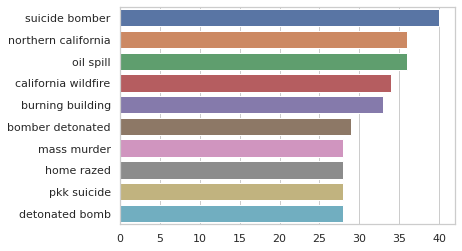

In [58]:
# top bigrams in disaster tweets
top_bigrams_disaster=get_top_ngram(train[train["target"] == 1]["text"],2)[:20]
x,y=map(list,zip(*top_bigrams_disaster))
sns.barplot(x=y,y=x)

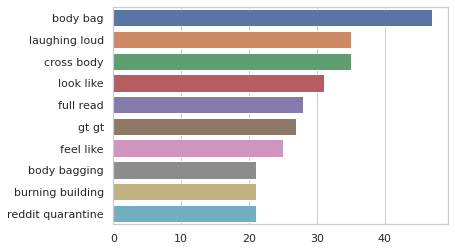

In [59]:
# top bigrams in non-disaster tweets
top_bigrams_nondisaster=get_top_ngram(train[train["target"] == 0]["text"],2)[:20]
x,y=map(list,zip(*top_bigrams_nondisaster))
sns.barplot(x=y,y=x)

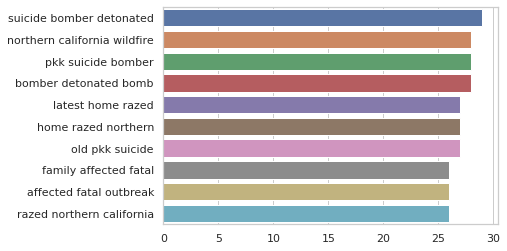

In [60]:
# top trigrams in disaster tweets
top_trigrams_disaster=get_top_ngram(train[train["target"] == 1]["text"],3)[:20]
x,y=map(list,zip(*top_trigrams_disaster))
sns.barplot(x=y,y=x)

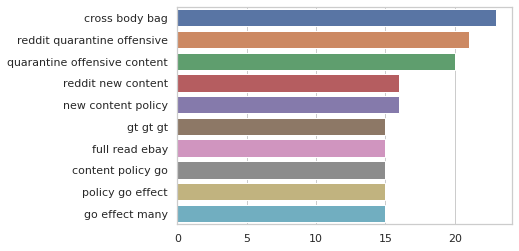

In [61]:
# top trigrams in non-disaster tweets
top_trigrams_nondisaster=get_top_ngram(train[train["target"] == 0]["text"],3)[:20]
x,y=map(list,zip(*top_trigrams_nondisaster))
sns.barplot(x=y,y=x)

We can create additional features from these most common n-grams. In the code below, I have selected the n-grams which seem most relevant to me and transformed them into features which will be used in training the model.

In [62]:
from sklearn import feature_extraction

#create the list of the n-grams that we want to use as features
lst_words = ['fire', 'news', 'disaster', 'like','amp','get', 'new','suicide bomber', 'northern california',
            'oil spill','california wildfire','burning building','bomber detonated', 'mass murder',
            'reddit quarantine','pkk suicide']
# count
lst_grams = [len(word.split(" ")) for word in lst_words]
vectorizer = feature_extraction.text.CountVectorizer(
                 vocabulary=lst_words, 
                 ngram_range=(min(lst_grams),max(lst_grams)))
train_X = pd.DataFrame(vectorizer.fit_transform(train["text"]).todense(), columns=lst_words)
test_X = pd.DataFrame(vectorizer.fit_transform(test["text"]).todense(), columns=lst_words)

# add the new features as columns
train = pd.concat([train, train_X.set_index(train.index)], axis=1)
test = pd.concat([test, test_X.set_index(test.index)], axis=1)
train.head()

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,...,new,suicide bomber,northern california,oil spill,california wildfire,burning building,bomber detonated,mass murder,reddit quarantine,pkk suicide
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1,7,7,0,0,5.142857,...,0,0,0,0,0,0,0,0,0,0
1,4,NaN,NaN,forest fire near la ronge sask canada,1,7,7,0,0,4.428571,...,0,0,0,0,0,0,0,0,0,0
2,5,NaN,NaN,resident asked shelter place notified officer ...,1,11,9,0,0,6.818182,...,0,0,0,0,0,0,0,0,0,0
3,6,NaN,NaN,13000 people receive wildfire evacuation order...,1,7,7,0,0,7.285714,...,0,0,0,0,0,0,0,0,0,0
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1,9,9,0,0,5.111111,...,0,0,0,0,0,0,0,0,0,0


### Topic Modeling

Topic modeling is the process of using unsupervised learning techniques to extract the main topics that occur in a collection of documents.

**Latent Dirichlet Allocation (LDA)** is an easy to use and efficient model for topic modeling. Each document is represented by the distribution of topics and each topic is represented by the distribution of words.


In [63]:
# transform tokens in a matrix using CountVectorizer
bag_of_words = CountVectorizer() 


# matrix for disaster tweets
bag_of_words.fit(train[train["target"] == 1]["text"])
real_bow =bag_of_words.transform(train[train["target"] == 1]["text"])
# matrix for non-disaster tweets
bag_of_words.fit(train[train["target"] == 0]["text"])
notreal_bow =bag_of_words.transform(train[train["target"] == 0]["text"])


real_bow=real_bow.todense()
notreal_bow=notreal_bow.todense()

In [65]:
 # Use GridSearch for best hyperparameters for the LDA model
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

# define search param-the most important ones which have an effect on the model if tuned
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

lda = LatentDirichletAllocation()

# initiate Grid Search Class
model_real = GridSearchCV(lda, param_grid=search_params)
model_notreal = GridSearchCV(lda, param_grid=search_params)

# fit the Grid Search
model_real.fit(real_bow)
model_notreal.fit(notreal_bow)

# find best parameters
lda_model_real = model_real.best_estimator_
lda_model_not_real = model_notreal.best_estimator_
#print("Best Model's Params: ", lda_model_real.best_params_)
#print("Best Model's Params: ", lda_model_not_real.best_params_)


In [139]:
# vizualize the topics for disaster tweets
# import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
#viz_real = pyLDAvis.sklearn.prepare(lda_model_real,real_bow,bag_of_words,mds='tsne')
#viz_real

In [79]:
# vizualize the topics for non-disaster tweets
viz_notreal=pyLDAvis.sklearn.prepare(lda_model_not_real,notreal_bow,bag_of_words, mds='tsne')
viz_notreal

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2      32.420952   8.115230       1        1  11.703726
9       0.648955  71.707100       2        1  11.528083
3      71.019684   9.971006       3        1  10.890497
5       3.785981  33.185135       4        1  10.733234
1     -42.666500  -9.222070       5        1   9.850751
8      -3.621689 -43.526516       6        1   9.515282
0      -3.632402  -4.171708       7        1   9.356743
6     -36.584400  35.804413       8        1   9.188581
4      44.391380  50.615383       9        1   9.116723
7      40.235809 -31.591665      10        1   8.116378, topic_info=        Term       Freq       Total Category  logprob  loglift
846     body  84.000000   84.000000  Default  30.0000  30.0000
4448    loud  54.000000   54.000000  Default  29.0000  29.0000
3271      gt  51.000000   51.000000  Default  28.0000  28.0000
556      bag  58.000000   58.000000  Default  27.0000  27.0000
6110  reddit  43.000000   43.000000  Default  26.0000  26.0000
...      ...        ...         ...      ...      ...      ...
3400    head   5.901112   30.723528  Topic10  -6.0666   0.8614
4329    like   6.943624  190.397257  Topic10  -5.9040  -0.8000
267      amp   6.055999  142.560554  Topic10  -6.0407  -0.6474
3230   great   5.670957   32.292228  Topic10  -6.1064   0.7718
8151    want   5.637419   61.571326  Topic10  -6.1124   0.1205

[677 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
7         4  0.757129        13
18        4  0.945611       320
30        5  0.889004       aba
57        1  0.053360  accident
57        2  0.053360  accident
...     ...       ...       ...
8449      6  0.041862      year
8449      7  0.041862      year
8449      8  0.481419      year
8449      9  0.083725      year
8514      2  0.753961     zouma

[1753 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 10, 4, 6, 2, 9, 1, 7, 5, 8])

**Observations**:
* Topic 2 is the most important area in non-disaster tweets as the area of the circle is the largest.
* Topic 10 is the least important.
* The are no topics which are every similar to each other(circles overlap).


Note: the documents can also be vectorized by using tf-idf, however, it won't make much of a difference. See [here](https://stackoverflow.com/questions/44781047/necessary-to-apply-tf-idf-to-new-documents-in-gensim-lda-model)

In [67]:
# show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords



In [68]:
# Topic - Keywords Dataframe for disaster tweets
topic_keywords_real = show_topics(bag_of_words, lda_model_real, n_words=10)    
df_topic_keywords_real = pd.DataFrame(topic_keywords_real)
df_topic_keywords_real.columns = ['Word '+str(i) for i in range(df_topic_keywords_real.shape[1])]
df_topic_keywords_real.index = ['Topic '+str(i) for i in range(df_topic_keywords_real.shape[0])]
df_topic_keywords_real


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,eyewitness,recognised,bore,arti,explain,represents,bento,individual,disdain,inspi
Topic 1,pumped,cow,faulty,cried,ohhhh,buts,diageo,cutting,gray,interested
Topic 2,plane,ohhhh,camper,mishap,huntington,placing,grey,boring,rang,member
Topic 3,charminar,division,ally,brilliant,died,evil,langley,gander,agnivesh,purse
Topic 4,disdain,bore,cannon,biolab,puledo,pone,powerful,reckon,deemed,individual
Topic 5,langley,echo,harassment,novel,islamic,aguero,rampage,homeland,minister,overload
Topic 6,itrawcwb,optimization,puledo,bentley,bennycapricon,commercial,lab,apologise,mistress,forsee
Topic 7,jobbing,individual,deutsch,goooooooo,adult,diablo,misery,head,hughes,blessed
Topic 8,conflict,introduction,practice,committee,clip,milwaukee,mwjcdk,last,climbed,inspi
Topic 9,kiernan,religion,murderer,ir,outside,last,barcelona,cle,gander,plane


In [69]:
# Topic - Keywords Dataframe for non-disaster tweets
topic_keywords_notreal = show_topics(bag_of_words, lda_model_not_real, n_words=10)   
df_topic_keywords_notreal = pd.DataFrame(topic_keywords_notreal)
df_topic_keywords_notreal.columns = ['Word '+str(i) for i in range(df_topic_keywords_notreal.shape[1])]
df_topic_keywords_notreal.index = ['Topic '+str(i) for i in range(df_topic_keywords_notreal.shape[0])]
df_topic_keywords_notreal


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,like,via,one,thank,amp,time,would,change,emergency,longer
Topic 1,body,bag,woman,new,cross,shoulder,bagging,lady,handbag,photo
Topic 2,would,get,full,still,like,amp,know,read,fatality,blown
Topic 3,loud,gt,laughing,bang,new,many,amp,quarantined,go,lava
Topic 4,reddit,content,video,new,fall,quarantine,offensive,get,cliff,come
Topic 5,make,fucking,amp,siren,screaming,mudslide,people,disaster,please,like
Topic 6,year,want,like,body,amp,crush,time,day,know,bag
Topic 7,wreck,back,one,news,storm,go,injury,could,scream,new
Topic 8,let,like,fire,cannot,mass,full,best,one,video,think
Topic 9,like,love,get,day,way,stock,crash,help,harm,market


### Sentiment Analysis

We can determine whether the text is positive, negative or neutral by using **Sentiment Analysis**.  This is a great tool for finding the sentiment associated with reviews, comments, articles, etc.

To perform the sentiment analysis we will use **Textblob** which has the following properties:
* **polarity**  (a floating-point number that lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement)
* **subjectivity** (a floating-point value which lies in the range of [0,1] where 0 means objective statement and 1 means very subjective statement, influenced mostly by personal opinion.

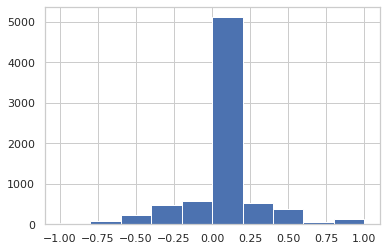

In [70]:
# import textblob
from textblob import TextBlob

#function for determining polarity
def polarity(text):
    return TextBlob(text).sentiment.polarity

#calculaing and vizualizing polarity for our text data
polarity_score=train["text"].apply(lambda x : polarity(x))
polarity_score.hist()

The **polarity score** is a float within the range [-1.0, 1.0]. According to TextBlob, the majority of the tweets are neutral as their polarity ranges between 0.00 and 0.20.

<BarContainer object of 3 artists>

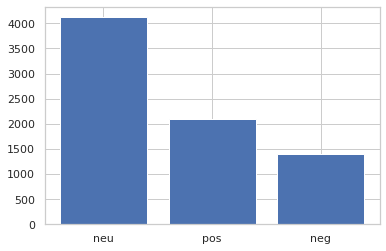

In [71]:
#determining the amount of positive, neutral and negative tweets

def sentiment(x):
    if x<0:
        return 'neg'
    elif x==0:
        return 'neu'
    else:
        return 'pos'
    
polarity=polarity_score.map(lambda x: sentiment(x))

plt.bar(polarity.value_counts().index,
        polarity.value_counts())

In [72]:
# display positive tweets
train[polarity=='pos']['text'].head()

1                 forest fire near la ronge sask canada
7                                top hill see fire wood
10                      three people died heat wave far
11    haha south tampa getting flooded hah wait seco...
16                                           love fruit
Name: text, dtype: object

In [73]:
# get the polarity and subjectivity values for a certain tweet
TextBlob(train['text'][10]).sentiment

Sentiment(polarity=0.1, subjectivity=1.0)

In [74]:
train['text'][10]

'three people died heat wave far'

This tweet has been labeled as kind of positive by TextBlob. 

Thus,as the Sentiment Analysis didn't work so well with TextBlob, we can try using VADER sentiment analysis for a comparison.

**VADER (Valence Aware Dictionary and sEntiment Reasoner**) is a lexicon and rule-based sentiment analysis tool that is specifically tuned to sentiments expressed in social media. VADER sentiment analysis class returns a dictionary that contains the probabilities of the text for being positive, negative and neutral. 

In [75]:
#import vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

# function for polarity score
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [76]:
#get the vader score for a certain tweet
sentiment_analyzer_scores(train['text'][10])

three people died heat wave far--------- {'neg': 0.419, 'neu': 0.581, 'pos': 0.0, 'compound': -0.5574}


The VADER score tells us more than the TextBlob polarity score. The same tweet has been labeled as 60% neutral and 40% negative, which would be closer to the truth.

<BarContainer object of 3 artists>

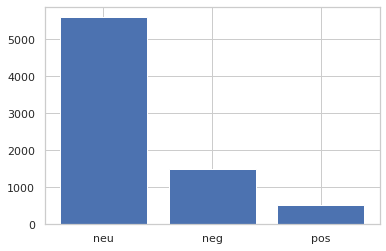

In [77]:
#determining the amount of positive, neutral and negative tweets
def get_vader_score(sent):
    ss = analyser.polarity_scores(sent)
    #return ss
    return np.argmax(list(ss.values())[:-1])

vad_score=train['text'].map(lambda x: get_vader_score(x))
polarity=vad_score.replace({0:'neg',1:'neu',2:'pos'})

plt.bar(polarity.value_counts().index,
        polarity.value_counts())

There is also a difference in distribution with more tweets labeled as neutral and less as positive or negative.

Next, we can include the Vader score as feature for both our train and test data.

In [78]:
# creating vader score feature
train["vad_score"] =vad_score
test['vad_score']=test['text'].map(lambda x: get_vader_score(x))

### Named Entity Recognition

**Named entity recognition** is an information extraction method in which entities that are present in the text are classified into predefined entity types like “Person”,” Place”,” Organization”, etc. By using NER we can get great insights about the types of entities present in the given text dataset.

In [80]:
# import necessary libraries
import spacy
from collections import Counter
import en_core_web_sm


In [81]:
#load the model for English trained on web data
nlp = en_core_web_sm.load()

# function to return ner labels
def ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]

# apply function to our dataset
ent=train['text'].apply(lambda x : ner(x))
ent=[x for sub in ent for x in sub]

# count  
counter=Counter(ent)
count=counter.most_common()

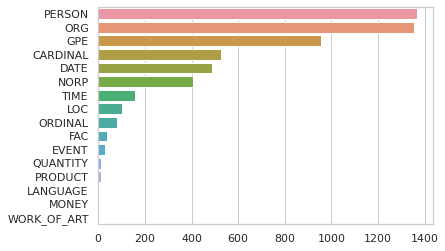

In [82]:
# vizualize frequency of name entities across the documents
x,y=map(list,zip(*count))
sns.barplot(x=y,y=x)

Below you can find a description of all Name Entities available in spacy:

<img src="https://i2.wp.com/neptune.ai/wp-content/uploads/spacy_ner.png?w=647&ssl=1"/>

In [83]:
# function to display a sentence
def ner_sen(text):
    doc=nlp(text)
    return [X for X in doc.sents]

# apply function to our dataset
ent=train['text'].apply(lambda x : ner_sen(x))

# print first 5 sentences
print(ent[:5])

0    [(deed, reason, earthquake, may, allah, forgiv...
1      [(forest, fire, near, la, ronge, sask, canada)]
2    [(resident, asked, shelter, place, notified, o...
3    [(13000, people, receive, wildfire, evacuation...
4    [(got, sent, photo, ruby, alaska, smoke, wildf...
Name: text, dtype: object


We can vizualize Name Entities in a sentence by using *displacy*. Each entity type is marked in different colors, which makes this a great tool for text data exploration.

In [84]:
# vizualize the name entities in the first 5 sentences
from spacy import displacy
displacy.render(nlp(str(ent[:5])), jupyter=True, style='ent')

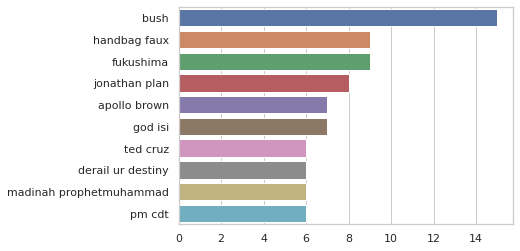

In [85]:
# function to visualize the most common tokens per entity
def common_tokens(text,ent):
    doc=nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

# apply function to count most common token in most common name entity
person=train['text'].apply(lambda x: common_tokens(x, "PERSON"))
person=[i for x in person for i in x]
counter=Counter(person)

x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

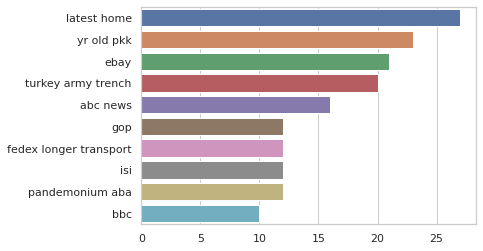

In [86]:
org=train['text'].apply(lambda x: common_tokens(x,"ORG"))
org=[i for x in org for i in x]
counter=Counter(org)

x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

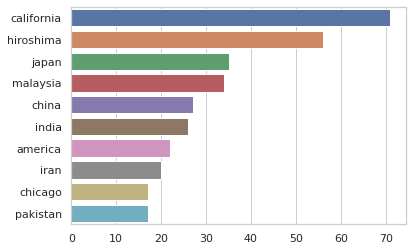

In [87]:
gpe=train['text'].apply(lambda x: common_tokens(x,"GPE"))
gpe=[i for x in gpe for i in x]
counter=Counter(gpe)

x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

This has been a pretty interesting analysis to run. Now, we can create new features from these tags which might increase the predictive power of our future model.

The code below puts all the recognized entities into a new column (named “tags”) along with the number of times these same entity appears in the text.Then it creates a new column for each tag category (Person, Org, Event, …) and counts the number of entities.

In [88]:
import collections

# tag text and extract tags into a list
train["tags"] = train["text"].apply(lambda x: [(tag.text, tag.label_) for tag in nlp(x).ents] )
test["tags"] = test["text"].apply(lambda x: [(tag.text, tag.label_) for tag in nlp(x).ents] )

# function to count the element of a list
def utils_lst_count(lst):
    dic_counter = collections.Counter()
    for x in lst:
        dic_counter[x] += 1
    dic_counter = collections.OrderedDict( 
                     sorted(dic_counter.items(), 
                     key=lambda x: x[1], reverse=True))
    lst_count = [ {key:value} for key,value in dic_counter.items() ]
    return lst_count

# apply function to our data
train["tags"] = train["tags"].apply(lambda x: utils_lst_count(x))
test["tags"] = test["tags"].apply(lambda x: utils_lst_count(x))

# function create new column for each tag category
def utils_features(lst_dics_tuples, tag):
    if len(lst_dics_tuples) > 0:
        tag_type = []
        for dic_tuples in lst_dics_tuples:
            for tuple in dic_tuples:
                type, n = tuple[1], dic_tuples[tuple]
                tag_type = tag_type + [type]*n
                dic_counter = collections.Counter()
                for x in tag_type:
                    dic_counter[x] += 1
        return dic_counter[tag]
    else:
        return 0

# function to extract features
def extract_ner(df):
    tags_set = []
    for lst in df["tags"].tolist():
         for dic in lst:
            for k in dic.keys():
                tags_set.append(k[1])
    tags_set = list(set(tags_set))
    for feature in tags_set:
         df["tags_"+feature] = df["tags"].apply(lambda x: utils_features(x, feature))

# apply function to both training and testing data
extract_ner(train)
extract_ner(test)






In [89]:
train

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,...,tags_QUANTITY,tags_MONEY,tags_FAC,tags_NORP,tags_GPE,tags_ORDINAL,tags_EVENT,tags_WORK_OF_ART,tags_TIME,tags_LOC
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1,7,7,0,0,5.142857,...,0,0,0,0,0,0,0,0,0,0
1,4,NaN,NaN,forest fire near la ronge sask canada,1,7,7,0,0,4.428571,...,0,0,1,0,0,0,0,0,0,0
2,5,NaN,NaN,resident asked shelter place notified officer ...,1,11,9,0,0,6.818182,...,0,0,0,0,0,0,0,0,0,0
3,6,NaN,NaN,13000 people receive wildfire evacuation order...,1,7,7,0,0,7.285714,...,0,0,0,0,1,0,0,0,0,0
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1,9,9,0,0,5.111111,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,two giant crane holding bridge collapse nearby...,1,8,8,0,0,5.500000,...,0,0,0,0,0,0,0,0,0,0
7609,10870,NaN,NaN,ahrary control wild fire california even north...,1,10,10,0,0,6.100000,...,0,0,0,0,1,0,0,0,0,0
7610,10871,NaN,NaN,km volcano hawaii,1,3,3,0,0,5.000000,...,0,0,0,0,0,0,0,0,0,0
7611,10872,NaN,NaN,police investigating e bike collided car littl...,1,17,15,0,0,5.764706,...,0,0,0,0,1,0,0,0,0,0


### POS Tagging

Parts of speech (POS) tagging assigns part of speech labels to words in a sentence. 

These are the main parts of speech: **Noun** (NN), **Verb** (VB), **Adjective** (JJ), **Adverb** (RB),**Preposition** (IN), **Conjunction** (CC), **Pronoun** (PRP), **Interjection** (INT)

In [90]:
# function for tagging parts of speech 
def pos(text):
    lis=[]
    pos=nltk.pos_tag(word_tokenize(text))
    for word,tag in pos:
            lis.append(tag)
    return lis


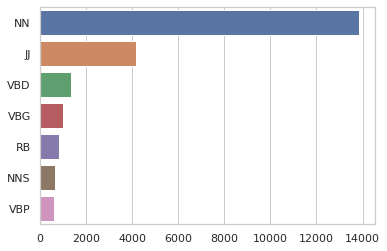

In [91]:
# apply function to our data and vizualize the most common parts of speech in disaster tweets
tags=train[train["target"]==1]["text"].apply(lambda x: pos(x))
tags=[x for l in tags for x in l]
counter=Counter(tags)


x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)
    

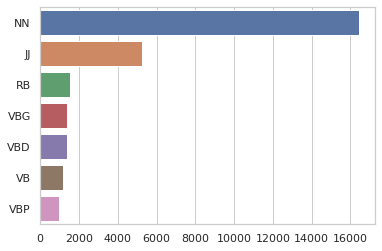

In [92]:
# vizualize the most common parts of speech in non-disaster tweets
tags=train[train['target']==0]['text'].apply(lambda x : pos(x))
tags=[x for l in tags for x in l]
counter=Counter(tags)

x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

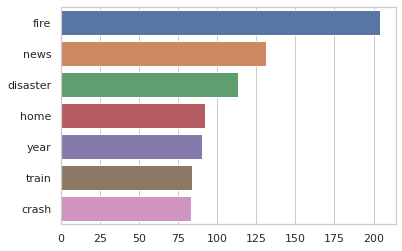

In [93]:
# function for determining the most common nouns 
def get_noun(text):
    noun=[]
    pos=nltk.pos_tag(word_tokenize(text))
    for word,tag in pos:
        if tag=='NN':
            noun.append(word)
    return noun

#apply function to our data and vizualize the most common nouns in disaster tweets
words=train[train['target']==1]['text'].apply(lambda x : get_noun(x))
words=[x for l in words for x in l]
counter=Counter(words)

x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

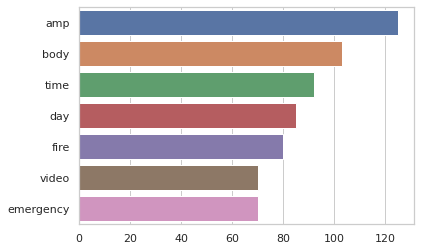

In [94]:
# vizualize the most common nouns in non-disaster tweets
words=train[train['target']==0]['text'].apply(lambda x : get_noun(x))
words=[x for l in words for x in l]
counter=Counter(words)

x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

We can again create extra features which will contain the number of times certain parts of speech appear in a tweet. These features could highlight the differences between disaster and non-disaster tweets.

In [95]:
# tag text and extract tags into a list
train["pos_tags"] = train["text"].apply(lambda x:nltk.pos_tag(word_tokenize(x)))
test["pos_tags"] = test["text"].apply(lambda x:nltk.pos_tag(word_tokenize(x)))

# count tags
train["pos_tags"] = train["pos_tags"].apply(lambda x: utils_lst_count(x))
test["pos_tags"] = test["pos_tags"].apply(lambda x: utils_lst_count(x))


# function to extract pos features
def extract_pos_feature(df):
    tags_set = []
    for lst in df["pos_tags"]:
        for dic in lst:
            for k in dic.keys():
                tags_set.append(k[1])
    tags_set = list(set(tags_set))
    for feature in tags_set:
          df["pos_tags_"+feature] = df["pos_tags"].apply(lambda x: utils_features(x, feature))


# apply funcion to our data
extract_pos_feature(train)
extract_pos_feature(test)





In [96]:
train

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,...,pos_tags_RBS,pos_tags_DT,pos_tags_VBG,pos_tags_NNP,pos_tags_PRP,pos_tags_UH,pos_tags_JJ,pos_tags_EX,pos_tags_VBP,pos_tags_NNS
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1,7,7,0,0,5.142857,...,0,0,0,0,0,0,1,0,0,0
1,4,NaN,NaN,forest fire near la ronge sask canada,1,7,7,0,0,4.428571,...,0,0,0,0,0,0,1,0,0,0
2,5,NaN,NaN,resident asked shelter place notified officer ...,1,11,9,0,0,6.818182,...,0,0,0,0,0,0,2,0,0,0
3,6,NaN,NaN,13000 people receive wildfire evacuation order...,1,7,7,0,0,7.285714,...,0,0,0,0,0,0,0,0,1,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1,9,9,0,0,5.111111,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,two giant crane holding bridge collapse nearby...,1,8,8,0,0,5.500000,...,0,0,1,0,0,0,2,0,0,0
7609,10870,NaN,NaN,ahrary control wild fire california even north...,1,10,10,0,0,6.100000,...,0,0,0,0,0,0,3,0,0,0
7610,10871,NaN,NaN,km volcano hawaii,1,3,3,0,0,5.000000,...,0,0,0,0,0,0,0,0,0,0
7611,10872,NaN,NaN,police investigating e bike collided car littl...,1,17,15,0,0,5.764706,...,0,0,2,0,0,0,4,0,0,1


I will now prepare the data set that will be used below for modelling. 

I will drop columns which are not bringing value and create a clean data set that can be then concatenated to the vectorized text.

In [97]:
#check current columns in training dataset
list(train.columns) 

['id',
 'keyword',
 'location',
 'text',
 'target',
 'word_count',
 'unique_word_count',
 'stop_word_count',
 'url_count',
 'mean_word_length',
 'char_count',
 'punctuation_count',
 'hashtag_count',
 'mention_count',
 'happy_emoji_count',
 'sad_emoji_count',
 'fire',
 'news',
 'disaster',
 'like',
 'amp',
 'get',
 'new',
 'suicide bomber',
 'northern california',
 'oil spill',
 'california wildfire',
 'burning building',
 'bomber detonated',
 'mass murder',
 'reddit quarantine',
 'pkk suicide',
 'vad_score',
 'tags',
 'tags_PERSON',
 'tags_CARDINAL',
 'tags_PRODUCT',
 'tags_LANGUAGE',
 'tags_ORG',
 'tags_DATE',
 'tags_QUANTITY',
 'tags_MONEY',
 'tags_FAC',
 'tags_NORP',
 'tags_GPE',
 'tags_ORDINAL',
 'tags_EVENT',
 'tags_WORK_OF_ART',
 'tags_TIME',
 'tags_LOC',
 'pos_tags',
 'pos_tags_IN',
 'pos_tags_RBR',
 'pos_tags_FW',
 'pos_tags_VBN',
 'pos_tags_WDT',
 'pos_tags_JJS',
 'pos_tags_CD',
 'pos_tags_RB',
 'pos_tags_VB',
 'pos_tags_NN',
 'pos_tags_CC',
 'pos_tags_WP',
 'pos_tags_TO',
 'p

In [98]:
#drop columns
#location is user input, thus dirty and unreliable
#keyword contains NaN
#text data will be vecorizeed and used below

clean_train=train.drop(['target','location','keyword','text', 'tags', 'pos_tags'], axis=1)
clean_test=test.drop(['location','keyword','text', 'tags', 'pos_tags','tags_LAW','pos_tags_SYM'], axis=1)
clean_train

,id,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,...,pos_tags_RBS,pos_tags_DT,pos_tags_VBG,pos_tags_NNP,pos_tags_PRP,pos_tags_UH,pos_tags_JJ,pos_tags_EX,pos_tags_VBP,pos_tags_NNS
0,1,7,7,0,0,5.142857,42,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,4,7,7,0,0,4.428571,37,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,5,11,9,0,0,6.818182,85,0,0,0,...,0,0,0,0,0,0,2,0,0,0
3,6,7,7,0,0,7.285714,57,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,7,9,9,0,0,5.111111,54,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,8,8,0,0,5.500000,51,0,0,0,...,0,0,1,0,0,0,2,0,0,0
7609,10870,10,10,0,0,6.100000,70,0,0,0,...,0,0,0,0,0,0,3,0,0,0
7610,10871,3,3,0,0,5.000000,17,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7611,10872,17,15,0,0,5.764706,114,0,0,0,...,0,0,2,0,0,0,4,0,0,1


In [99]:
clean_test.shape

(3263, 75)

In [100]:
clean_train.shape

(7613, 75)

## Machine Learning

**Vectorization** helps us transform words to numbers so that they can be processed by a computer.

There are several methods to achieve that:
* One-Hot Encoding- encodes words into vectors containing binary variables 0 and 1
* CountVectorizer- transforms text data into a **Bag of Words (BoW)**, which is a representation of text data that counts how many times a word appears in a document.
* TfidfVectorizer- transforms data into **Term Frequency-Inverse Document Frequency**, an approach to rescale the frequency of words by how often they appear in all documents so that the scores for frequent words like “the” that are also frequent across all documents are penalized. In other words, the Tfidf method helps to bring down the weight/impact of high-frequency words. 
* Word Embeddings- derives vector representations for words by using a Deep Learning method. *Words with similar meaning get a similar vector representation*, meaning that word embeddings are very good at understanding context as well as other semantical/morphological/context/hierarchical information.

Thus, BoW measures *frequency* of words, TF-IDF measures *relevance*, while Word Embeddings capture *context*. 


We will now try applying some traditional machine learning algorithms using data vectorized with CountVectorizer and TfidfVectorizer and after, we will experiment with GloVe. We do this in order to get the chance to see the difference between all these vectorization methods.

### Bag of Words

In [101]:
# transform train and test data into a vector using bag of words approach
bag_of_words = CountVectorizer() 
bag_of_words.fit(train['text'])
train_bow = bag_of_words.transform(train['text'])
test_bow = bag_of_words.transform(test['text'])

In [102]:
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler

#standardize the data
scaler = StandardScaler(with_mean=False)
scaler.fit_transform(train_bow)
scaler.fit(test_bow)

#normalize data
scaler_1 = MaxAbsScaler()
scaler_1.fit_transform(train_bow)
scaler_1.fit(test_bow)


#merging the additional features with the vectorized text and the transforming the 
#outcome into a sparse matrix
train_bow = hstack([train_bow, clean_train.values]).tocsr()
test_bow = hstack([test_bow, clean_test.values]).tocsr()


#transforming the sparse matrix into an numpy array
train_bow =train_bow.toarray()
test_bow=test_bow.toarray()

#replacing NaN values
train_bow = np.nan_to_num(train_bow)
test_bow = np.nan_to_num(test_bow)




### TF-IDF

In [103]:
# transform train and test data into a vector using Tfidf approach
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
tfidf.fit(train['text'])
train_tfidf = tfidf.transform(train['text'])
test_tfidf = tfidf.transform(test['text'])

In [104]:
#standardize the data
scaler.fit_transform(train_tfidf)
scaler.fit(test_tfidf)

#normalize data
scaler_1.fit_transform(train_tfidf)
scaler_1.fit(test_tfidf)


#merging the additional features with the vectorized text and transforming 
#the outcome in a sparse matrix
train_tfidf = hstack([train_tfidf, clean_train.values]).tocsr()
test_tfidf = hstack([test_tfidf, clean_test.values]).tocsr()


#transforming the sparse matrix into an numpy array
train_tfidf =train_tfidf.toarray()
test_tfidf=test_tfidf.toarray()

#replacing NaN values
train_tfidf = np.nan_to_num(train_tfidf)
test_tfidf = np.nan_to_num(test_tfidf)



In this project we will use the F1 score as an evaluation metric.

**F1-score** is the percentage of **correct** positive results within all positive results returned by the classifier.The score reaches its best value at 1.

The F1 Score is the harmonic mean of the Precision and Recall:
* *precision*, also called the positive predictive value, is the proportion of positive results that truly are positive.
* *recall*, also called sensitivity, is the ability of a test to correctly identify positive results to get the true positive rate.

In [105]:
#importing necessary libraries for machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

We will test more algorithms and choose the one with the highest F1 score and the best predictive power.

In [106]:
#creating a dictionary for algorithms
ESTIMATORS = {
    "Logistic Regression": LogisticRegression(max_iter=100000),
    "Random Forest": RandomForestClassifier(),
    "Multinomial NB":MultinomialNB(),
    "Bernoulli NB": BernoulliNB(),
    "Ridge":RidgeClassifier(max_iter=100000),
    "SVC": SVC(max_iter=100000),
    "LinearSVC ": LinearSVC(max_iter=100000),
    "Decision Tree":DecisionTreeClassifier(),
    "KNeighbors":KNeighborsClassifier(),
    "XGBoost": xgb.XGBClassifier()
    
}

We will calculate the scores for each model by using, first, the BoW data, and then, the Tfidf data.

In [107]:
#defining the target variable
y= train['target']

In [108]:
from sklearn.model_selection import cross_val_score

# creating a dictionary to store the the scores for the models
y_score = dict()

# fitting the BoW data to the algorithms
for name, estimator in ESTIMATORS.items():  
    y_score[name]=cross_val_score(estimator, train_bow, y, cv=5, scoring='f1').mean()
    
# obtaining the F1 scores for each algorithm
y_score

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

{'Logistic Regression': 0.583578019569633,
 'Random Forest': 0.42642671730215626,
 'Multinomial NB': 0.6165553591703656,
 'Bernoulli NB': 0.6251507186144394,
 'Ridge': 0.5482242074880245,
 'SVC': 0.11986754966887417,
 'LinearSVC ': 0.3749280567548453,
 'Decision Tree': 0.3836889147199555,
 'KNeighbors': 0.3390194142179994,
 'XGBoost': 0.37941939948530934}

In [109]:
# creating dictionaries to store the predicted values and the scores for the models
y_score = dict()

# fitting the tfidf data to the algorithms
for name, estimator in ESTIMATORS.items():    
    y_score[name]=cross_val_score(estimator, train_tfidf, y, cv=5, scoring='f1').mean()
    
# obtaining the F1 scores for each algorithm
y_score

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

{'Logistic Regression': 0.5219682622195142,
 'Random Forest': 0.41835855138212014,
 'Multinomial NB': 0.5813159876156921,
 'Bernoulli NB': 0.5993785312761455,
 'Ridge': 0.5808102783772707,
 'SVC': 0.1215578716401536,
 'LinearSVC ': 0.18648718742425247,
 'Decision Tree': 0.37755952773895773,
 'KNeighbors': 0.3390194142179994,
 'XGBoost': 0.38013741829938075}

**Observations:**
* using the data transformed with CountVectorizer gives slightly higher score, thus, we will use the BoW approach when fitting the 'chosen' model and when making predictions. 
* Bernoulli Naive Bayes is the model which perform best.

In [110]:
# performing a GridSearchCV to find better parameters for the best performing algorithm

from sklearn.model_selection import GridSearchCV

model=BernoulliNB()
search_grid={ 'alpha': [0.001, 0.01, 0.1, 1, 10, 100], 'fit_prior': [True, False]}
search= GridSearchCV(model, search_grid, n_jobs=-1,cv=5, scoring='f1')
search.fit(train_bow,y)
print(search.best_params_)
print(search.best_score_)

{'alpha': 0.1, 'fit_prior': False}
0.6380580195926032


After using GridSearchCV to find the best parameters for the best performing algorithms, we see that a Bernoulli Naive Bayes algorithm with an alpha value of 0.1 and an uniform prior gives the highest F1 score- 0.638.

We can also try a different approach by using **The Voting Classifier**.

A Voting Classifier is a machine learning model that trains on an ensemble of numerous models and predicts an output (class) based on their highest probability of chosen class as the output.

It simply aggregates the findings of each classifier passed into Voting Classifier and predicts the output class based on the highest majority of voting. The idea is instead of creating separate dedicated models and finding the accuracy for each them, we create a single model which trains by these models and predicts output based on their combined majority of voting for each output class.

The classifier supports two types of voting:
* Hard- where the predicted output is the class which had the highest probability of being predicted by each of the classifiers.
* Soft- the output class is the prediction based on the average of probability given to that class (similar to what we did above by taking the mean of the f1 score array for each model). 

We will define the VotingClassifier using all the algorithms above except the Ridge Classifier, SVC and Linear SVC models, which do not support the *predict_proba* function.
We will also test both types of voting and train the model on the train_bow.

In [111]:
from sklearn.ensemble import VotingClassifier 
LR=LogisticRegression(C=0.7, max_iter=100000)
NB=BernoulliNB(alpha=0.1,fit_prior=False)
RF=RandomForestClassifier()
DT=DecisionTreeClassifier()
KN=KNeighborsClassifier()
XGB=xgb.XGBClassifier()
models=[('LogisticRegression',LR),
        ('Naive Bayes', NB),
        ('Random Forest',RF),
        ('DecisionTree Classifier',DT),
        ('K-Nerarest Neighbour', KN),
        ('XGBoost Classifier',XGB)]

#testing soft voting
classifier_vc = VotingClassifier(voting = 'soft',estimators= models)
score= cross_val_score(classifier_vc, train_bow, y,cv=5, scoring='f1').mean()
score

0.4136527040824978

In [112]:
#testing hard voting
classifier_vc_1 = VotingClassifier(voting = 'hard',estimators= models)
score= cross_val_score(classifier_vc_1, train_bow, y, cv=5, scoring='f1').mean()
score

0.4040439936733091

**Observation:**
* The Voting Classifier gives a very poor results
* Soft Voting scores better in our case than hard voting

### GloVe

Now let's try out word embeddings and Deep Learning!

There are several techniques that can be used to learn a word embedding from text data. The most famous are:
* Word2Vec
* GloVe
* fasttext

In this notebook we will use the GloVe technique(for first time).

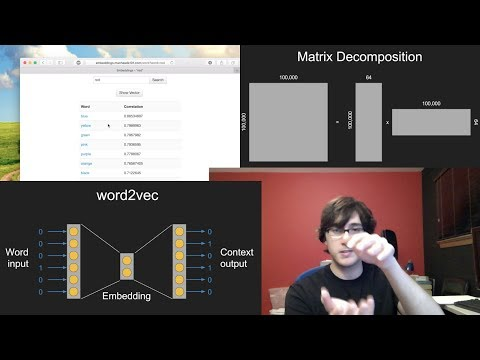

In [113]:
#very good explanation for word embeddings
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo('5PL0TmQhItY',width=600, height=400)

In [114]:
#importing necessary libraries
from tqdm import tqdm
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *


In [115]:
pip install mltb

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [116]:
#function for creating corpus out of text data
def create_corpus_new(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet)]
        corpus.append(words)
    return corpus   

In [117]:
#apply function to our data
create_corpus_new(train)

100%|██████████| 7613/7613 [00:01<00:00, 4872.98it/s]


[['deed', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'u'],
 ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada'],
 ['resident',
  'asked',
  'shelter',
  'place',
  'notified',
  'officer',
  'evacuation',
  'shelter',
  'place',
  'order',
  'expected'],
 ['13000',
  'people',
  'receive',
  'wildfire',
  'evacuation',
  'order',
  'california'],
 ['got',
  'sent',
  'photo',
  'ruby',
  'alaska',
  'smoke',
  'wildfire',
  'pours',
  'school'],
 ['closed',
  'direction',
  'due',
  'lake',
  'county',
  'fire',
  'cafire',
  'wildfire'],
 ['flood',
  'disaster',
  'heavy',
  'rain',
  'cause',
  'flash',
  'flooding',
  'street',
  'manitou',
  'colorado',
  'spring',
  'area'],
 ['top', 'hill', 'see', 'fire', 'wood'],
 ['emergency', 'evacuation', 'happening', 'building', 'across', 'street'],
 ['afraid', 'tornado', 'coming', 'area'],
 ['three', 'people', 'died', 'heat', 'wave', 'far'],
 ['haha',
  'south',
  'tampa',
  'getting',
  'flooded',
  'hah',
  'wait',
  'seco

In [118]:
from scipy import spatial
from sklearn.manifold import TSNE

#creating dictionary for all the words present in the embedding file
embedding_vector = {}

# load the pre-trained vectors
f=open('/kaggle/input/glove840b300dtxt/glove.840B.300d.txt')
for line in tqdm(f):
    values=line.split(' ')
    word = values[0]
    vectors=np.asarray(values[1:],'float32')
    embedding_vector[word]=vectors


#initialize the Tokenizer object imported from Keras library
token=Tokenizer()
#fit the tokenizer on our text, which will assign a unique number to each word
token.fit_on_texts(corpus)
#converts each sentence into a sequence of numbers
sequences=token.texts_to_sequences(corpus)
#padding the sequence and making all sentences have a uniform length
pad_seq=pad_sequences(sequences,maxlen=50)
#defining the vocabulary size
vocab_size=len(token.word_index)+1
#creating a matrix which contains only words from our vocabulary and their corresponding vector
embedding_matrix=np.zeros((vocab_size,300))
for word,i in tqdm(token.word_index.items()):
    if i < vocab_size:
        embedding_value=embedding_vector.get(word)
        if embedding_value is not None:
            embedding_matrix[i]=embedding_value  

2196018it [05:17, 6913.41it/s]
100%|██████████| 22700/22700 [00:00<00:00, 253378.98it/s]


In [119]:
train_data=pad_seq[:train.shape[0]]
test_data=pad_seq[train.shape[0]:]
y=train['target']

In [120]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(train_data,y,test_size=0.2)

In [122]:
import mltb.keras

#creating a simple sequential Keras model
model=Sequential()

#adding layers
model.add(Embedding(vocab_size,300,weights=[embedding_matrix],input_length=50,trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

#adding loss function, metrics, optimizer
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

#adding callbacks
bcm_callback = mltb.keras.BinaryClassifierMetricsCallback(X_test, y_test)
es_callback = EarlyStopping(monitor='val_f1', patience=5,  mode='max')
mc=ModelCheckpoint('best_model.h5', monitor='val_f1', mode='max', save_best_only=True,verbose=1)  

#model summary
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           6810300   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 6,903,805
Trainable params: 93,505
Non-trainable params: 6,810,300
_________________________________________________________________
None


**For custom metrics in Keras see** [here](https://github.com/PhilipMay/mltb#module-keras).

In [123]:
#training the model
history=model.fit(X_train,y_train,batch_size=128,epochs=1000,verbose=2,callbacks=[bcm_callback, es_callback,mc])

Train on 6090 samples
Epoch 1/1000

Epoch 00001: val_f1 improved from -inf to 0.04329, saving model to best_model.h5
6090/6090 - 10s - loss: 0.6874 - acc: 0.5558
Epoch 2/1000

Epoch 00002: val_f1 improved from 0.04329 to 0.04885, saving model to best_model.h5
6090/6090 - 6s - loss: 0.6786 - acc: 0.5741
Epoch 3/1000

Epoch 00003: val_f1 improved from 0.04885 to 0.07293, saving model to best_model.h5
6090/6090 - 6s - loss: 0.6777 - acc: 0.5808
Epoch 4/1000

Epoch 00004: val_f1 improved from 0.07293 to 0.07531, saving model to best_model.h5
6090/6090 - 7s - loss: 0.6748 - acc: 0.5823
Epoch 5/1000

Epoch 00005: val_f1 improved from 0.07531 to 0.11503, saving model to best_model.h5
6090/6090 - 5s - loss: 0.6707 - acc: 0.5877
Epoch 6/1000

Epoch 00006: val_f1 improved from 0.11503 to 0.20024, saving model to best_model.h5
6090/6090 - 6s - loss: 0.6704 - acc: 0.5903
Epoch 7/1000

Epoch 00007: val_f1 did not improve from 0.20024
6090/6090 - 5s - loss: 0.6680 - acc: 0.5934
Epoch 8/1000

Epoch 0

In [125]:
#evaluation of best model
_,val_f1 = model.evaluate(X_test,y_test, batch_size=128)
print(val_f1)

1523/1523 [==============================] - 1s 512us/sample - loss: 0.6983 - acc: 0.5240
0.52396584


The F1 score is lower than the one obtained with Bernoulli Naive Bayes algorithm. So what went wrong? Aren't pretrained embeddings supposed to give better results just because they're trained on billions of words?

One probability is that these pretrained embeddings are not trained against text in the same context, and that the number of common words between our text and the text of these pretrained embeddings is low. Moreover, in the Bernoulli model we have used other engineered features for training and prediction.

### BERT

Although Word Embeddings do a much better job at capturing context and look like a more interesting and complex technique than the traditional vectorization and machine learning algorithms, there is an even better way to solve NLP problems-- **Language Models**.

The biggest limitation of Word Embeddings is that they presume that the word’s meaning is relatively stable across sentences, which is not the case. Pre-trained Language models, however, capture many facets of language, such as long-term dependencies, hierarchical relations, and sentiment.

In this notebook I would like to make a first ever attempt at using **BERT**, short for *Bidirectional Encoder Representations from Transformers*.

Below you can find a video which explains very well the intuition behind BERT.

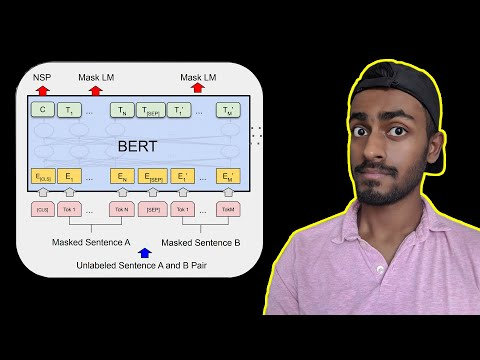

In [126]:
#explanation for BERT
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo('xI0HHN5XKDo',width=600, height=400)

In [127]:
!pip install bert-for-tf2

     |████████████████████████████████| 40 kB 2.3 MB/s eta 0:00:011
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.4-py3-none-any.whl size=30114 sha256=686f0e1cf11f80d8f87ed0a148f7d41597f2b963e47cc8b12be7151969699938
  Stored in directory: /root/.cache/pip/wheels/6c/c9/9c/363182ea34a736dae336eeaf0dd4a7eec3c6a5afe32373e1fe
  Created wheel for py-params: filename=py_params-0.9.7-py3-none-any.whl size=7302 sha256=eb0febb53d610e72e4c382c0a4c8128a5860b1ebcace216ac52283ae56cf3d38
  Stored in directory: /root/.cache/pip/wheels/47/3d/2d/bbffcfd6b9f4b8b5cbf07e7520ac2676192fe9431240c13ee8
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19473 sha256=3c219a89168024e97564db81d5b3b52bb4ec45191f11307d6c1505fa38c4b906
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
Successfully built bert-for-tf2 py-params params-flow
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install 

In [128]:
import tensorflow_hub as hub
#load BERT
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [129]:
import bert
import torch
from transformers import BertTokenizer


# Loading the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
#creating function for input formattting

#create function to fromat input
def formatting (documents,tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    for data in documents:
        #split sentences into tokens
        text = tokenizer.tokenize(data)
        text = text[:max_len-2]
        #add the special tokens [CLS] and[SEP]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        #pad all sentences to have the same length
        pad_len = max_len - len(input_sequence)
        #map the tokens to their ids    
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        #create masks
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        #create segment ids
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    #return input as array
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)


In [130]:
#split data for validation purposes
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(train['text'],train['target'],test_size=0.2)

In [131]:
#applying formatting function to our data
X_train=formatting(X_train.values, tokenizer, max_len=260)
X_test=formatting(X_test.values, tokenizer, max_len=260)

#preparing test data
y_test=y_test.values
y_train=y_train.values

In [132]:
import mltb.keras

#Building BERT model

def build_model(bert_layer, max_len=512):
    #adding input layers
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    #adding inner layers
    dense_layer1 = Dense(units=256,activation='relu')(clf_output)
    dense_layer1 = Dropout(0.4)(dense_layer1)
    dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
    dense_layer2 = Dropout(0.4)(dense_layer2)
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    return model



In [134]:
import tensorflow as tf

model = build_model(bert_layer, max_len=260)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 260)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 260)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 260)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [135]:
#define the callbacks
#bcm and es callbacks are used in case we want to define custom metrics
#mc saves and evaluates the best model
bcm_callback = mltb.keras.BinaryClassifierMetricsCallback(X_test,y_test)
es_callback = EarlyStopping(monitor='val_f1', patience=5,  mode='max')
mc=ModelCheckpoint('model.h5', monitor='val_f1', mode='max', save_best_only=True, verbose=1)
#fit model to training data
train_history = model.fit(X_train, y_train,
    epochs=10,
    callbacks=[bcm_callback,es_callback, mc],
    batch_size=32
)

Train on 6090 samples
Epoch 1/10
6080/6090 [============================>.] - ETA: 0s - loss: 0.5657 - accuracy: 0.7095
Epoch 00001: val_f1 improved from -inf to 0.68785, saving model to model.h5
6090/6090 [==============================] - 222s 36ms/sample - loss: 0.5656 - accuracy: 0.7097
Epoch 2/10
6080/6090 [============================>.] - ETA: 0s - loss: 0.4447 - accuracy: 0.7919
Epoch 00002: val_f1 improved from 0.68785 to 0.73094, saving model to model.h5
6090/6090 [==============================] - 201s 33ms/sample - loss: 0.4447 - accuracy: 0.7920
Epoch 3/10
6080/6090 [============================>.] - ETA: 0s - loss: 0.3850 - accuracy: 0.8299
Epoch 00003: val_f1 improved from 0.73094 to 0.74979, saving model to model.h5
6090/6090 [==============================] - 202s 33ms/sample - loss: 0.3847 - accuracy: 0.8299
Epoch 4/10
6080/6090 [============================>.] - ETA: 0s - loss: 0.3220 - accuracy: 0.8637
Epoch 00004: val_f1 did not improve from 0.74979
6090/6090 [====

In [136]:
#evaluate best model
_,val_f1 = model.evaluate(X_test,y_test, batch_size=32)
print(val_f1)

1523/1523 [==============================] - 18s 12ms/sample - loss: 0.5837 - accuracy: 0.7800
0.78003937


As we can see, BERT helped us obtain the best f1-score: **0.78**. No wonder all NLP practitioners are fascinated by this new breakthrough in the field. 

## Prediction and Submission

In [137]:
#applying formatting function to test dataset
test_input=formatting(test.text.values, tokenizer, max_len=260)

In [138]:
#predicting
test_pred = model.predict(test_input)

#prepare submission file
submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission['target'] = test_pred.round().astype(int)
submission.to_csv('submission.csv', index=False)

## Conclusion and Discussion

This notebook was my first attempt with text data, I have tried to apply the most important NLP techniques while predicting whether a tweet is a disaster tweet or not.

**I have obtained the following results:**
* an F1-score of **0.638** while using the Bernoulli Naive Bayes algorithm on data vectorized with CountVectorizer. The inut data contained the text features as well as other engineered features created using n-grams, name entity recognition, sentiment analysis, pos tagging and name entity recognition.
* a F1-score of **0.524** using the GloVe pretrained Word Embeddings on text features only
* a F1-score of **0.780** using the BERT language model on text features only

**What else could have been done to improve the final score?**
* do feature selection on all features used for the Bernoulli Naive Bayes algorithm
* do parameter tuning for all algorithms used
* use engineered features with GloVe and BERT as well
* experiment with other pre-trained embeddings/train embeddings myself instead of using pre-trained ones
* use k-fold for validation instead of train_test_split
* try ensembles of different models and embeddings.

## References

https://www.kaggle.com/parulpandey/getting-started-with-nlp-a-general-intro
https://www.kaggle.com/kushbhatnagar/disaster-tweets-eda-nlp-classifier-models
https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert
https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert/log
https://www.kaggle.com/ratan123/start-from-here-disaster-tweets-eda-basic-model
https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/
https://towardsdatascience.com/your-guide-to-natural-language-processing-nlp-48ea2511f6e1
https://medium.com/@kamilmysiak/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d
https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a
https://www.geeksforgeeks.org/ml-voting-classifier-using-sklearn/
https://mc.ai/glove-word-embeddings-with-keras-python-code/
https://www.kaggle.com/basu369victor/learning-bert-for-the-first-time
https://www.kaggle.com/ratan123/in-depth-guide-to-google-s-bert
https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/
https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d
https://github.com/PhilipMay/mltb#module-keras
https://www.analyticsvidhya.com/blog/2020/03/pretrained-word-embeddings-nlp/
https://mccormickml.com/2019/07/22/BERT-fine-tuning/
http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/
https://www.kaggle.com/sbongo/do-pretrained-embeddings-give-you-the-extra-edge
